# deepBreaks applications
## deepBreaks reveals important SARS-CoV-2 regions associated with Alpha and Delta variants  
Variants occur with new mutations in the virus genome. Most mutations in the SARS-CoV-2 genome do not affect the functioning of the virus. However, mutations in the spike protein of SARS-CoV-2, which binds to receptors on cells lining the inside of the human nose, may make the virus easier to spread or affect how well vaccines protect people. Other mutations may lead to SARS-CoV-2 being less responsive to treatments for COVID-19. Variants of SARS-CoV-2 have been categorized into multiple variants, but based on their effect on public health, only five of these have been labeled as variants of concern. Among these five variants, we are going to study the mutations in the spike protein of the sequences of Alpha (B.1.1.7): the first variant of concern described in the United Kingdom (UK) in late December 2020 and Delta (B.1.617.2): first reported in India in December 2020. We used the publicly available data from the GSAID28 and obtained 900 sequences of spike protein region of Alpha (450 samples) and Delta (450 samples) variants. We used MAFFT algorithm with PAM 200 to align these sequences. Then, we used deepBreaks to analyze the data and find the most important (predictive) positions in these sequences in terms of classifying the variants.


In [1]:
# importing deepBreaks libraries 
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '/Users/mbagh/Documents/RahLab/deepBreaks_data/covid/sarscov2_2.fasta'
meta_data = '/Users/mbagh/Documents/RahLab/deepBreaks_data/covid/meta_data_clean.csv'
# name of the phenotype
mt = 'variant_short'

# type of the sequences
seq_type = 'nu'
# type of the analysis if it is a classification model, then we put cl instead of reg
anaType = 'cl'
sampleFrac=1

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [30]:
%%time
# importing sequences data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True)
metaData = prp.read_data(meta_data, is_main=False)
positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading fasta file
Done
Shape of data is:  (901, 3822)
CPU times: user 2.97 s, sys: 15.4 ms, total: 2.98 s
Wall time: 2.98 s


In [31]:
df.index = [ind[:-7] for ind in df.index]

**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [32]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


,Accession.ID,Location,Host,Patient.age,Gender,Clade,Variant,variant_short
hCoV-19/England/LOND-1352661/2021,EPI_ISL_2517656,Europe / United Kingdom / England,Human,unknown,unknown,GK,VOC Delta GK (B.1.617.2+AY.*) first detected i...,Delta
hCoV-19/India/DL-CT30/2021,EPI_ISL_2426214,Asia / India / Delhi,Human,56,Male,GK,VOC Delta GK (B.1.617.2+AY.*) first detected i...,Delta
hCoV-19/Spain/CT-BST9925432235/2021,EPI_ISL_2534468,Europe / Spain / Cataluna / Torelló,Human,18,Female,GK,VOC Delta GK (B.1.617.2+AY.*) first detected i...,Delta
hCoV-19/Italy/TAA-IGA-1900597885/2021,EPI_ISL_2517122,Europe / Italy / Trentino-Alto Adige,Human,46,Female,GK,VOC Delta GK (B.1.617.2+AY.*) first detected i...,Delta
hCoV-19/USA/CA-CDC-FG-036855/2021,EPI_ISL_2527796,North America / USA / California,Human,50,unknown,GK,VOC Delta GK (B.1.617.2+AY.*) first detected i...,Delta


In [33]:
# selecting only the classes with enough number of samples
df = prp.balanced_classes(dat=df, meta_dat=metaData, feature=mt)

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [34]:
%%time
# taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
df = prp.missing_constant_care(df, missing_threshold=0.25)
print('Shape of data after missing/constant care: ', df.shape)

Shape of data before missing/constant care:  (896, 3822)
Shape of data after missing/constant care:  (896, 316)
CPU times: user 2.08 s, sys: 6.35 ms, total: 2.09 s
Wall time: 2.08 s


In [35]:
%%time
# taking care of ultra-rare cases
print('Shape of data before imbalanced care: ', df.shape)
df = prp.imb_care(dat=df)
print('Shape of data after imbalanced care: ', df.shape)

Shape of data before imbalanced care:  (896, 316)
Shape of data after imbalanced care:  (896, 28)
CPU times: user 338 ms, sys: 9.02 ms, total: 347 ms
Wall time: 338 ms


In [36]:
df.head()

,p56,p203,p204,p205,p206,p207,p208,p284,p425,p429,...,p665,p1355,p1433,p1501,p1709,p2042,p2147,p2848,p2944,p3352
hCoV-19/England/LOND-1352661/2021,G,T,A,C,A,T,G,C,A,T,...,C,G,A,A,C,G,C,A,T,G
hCoV-19/England/ALDP-15F5CF3/2021,G,T,A,C,A,T,G,T,A,T,...,C,G,A,A,C,G,C,A,T,G
hCoV-19/USA/CA-CDC-FG-036855/2021,G,T,A,C,A,T,G,C,A,T,...,C,G,A,A,C,G,C,A,T,G
hCoV-19/Canada/BC-BCCDC-55845/2021,G,T,A,C,A,T,G,C,A,T,...,C,G,A,A,C,G,C,A,T,G
hCoV-19/USA/TX-CDC-FG-035592/2021,G,T,A,C,A,T,G,C,A,T,...,C,G,A,A,C,G,C,A,T,G


In [37]:
%%time
# Use statistical tests to drop redundant features.
print('number of columns of main data befor: ', df.shape[1])
df_cleaned = prp.redundant_drop(dat=df, meta_dat=metaData,
                        feature=mt, model_type=anaType,
                        threshold=0.25,
                        report_dir=report_dir)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  28
number of columns of main data after:  28
CPU times: user 127 ms, sys: 3.45 ms, total: 130 ms
Wall time: 128 ms


In [38]:
%%time
print('one-hot encoding the dataset')
df_cleaned = prp.get_dummies(dat=df_cleaned, drop_first=True)

one-hot encoding the dataset
CPU times: user 28 ms, sys: 2.44 ms, total: 30.4 ms
Wall time: 28.6 ms


In [39]:
%%time
print('calculating the distance matrix')
cr = prp.distance_calc(dat=df_cleaned,
                       dist_method='correlation',
                       report_dir=report_dir)
print(cr.shape)

calculating the distance matrix
(28, 28)
CPU times: user 9.68 ms, sys: 3.14 ms, total: 12.8 ms
Wall time: 10.8 ms


In [40]:
print('The distance matrix looks like this.\n The values are between 0 (exact the same) and 1 (non-related).')
cr.head()

The distance matrix looks like this.
 The values are between 0 (exact the same) and 1 (non-related).


,p56_G,p203_T,p204_GAP,p205_GAP,p206_GAP,p207_T,p208_GAP,p284_T,p425_G,p429_T,...,p665_T,p1355_T,p1433_C,p1501_T,p1709_C,p2042_G,p2147_T,p2848_G,p2944_T,p3352_G
p56_G,0.000000,0.285784,0.276610,2.747864e-01,2.747864e-01,0.284082,0.298362,0.567189,0.411313,0.147638,...,0.750632,0.106049,0.101957,0.102416,0.033090,0.028845,0.052410,0.073474,0.029035,0.037558
p203_T,0.285784,0.000000,0.012174,2.187053e-02,2.187053e-02,0.019536,0.043809,0.427610,0.250705,0.213696,...,0.791764,0.314799,0.298575,0.295249,0.298452,0.296415,0.299327,0.352035,0.295589,0.289115
p204_GAP,0.276610,0.012174,0.000000,9.816189e-03,9.816189e-03,0.017195,0.031939,0.420181,0.241282,0.214575,...,0.787893,0.306387,0.290004,0.286515,0.288989,0.287048,0.289632,0.343433,0.286374,0.279617
p205_GAP,0.274786,0.021871,0.009816,0.000000e+00,1.110223e-16,0.012246,0.032208,0.414134,0.233611,0.213305,...,0.784752,0.305204,0.288686,0.285059,0.286930,0.285068,0.287386,0.342087,0.284517,0.277530
p206_GAP,0.274786,0.021871,0.009816,1.110223e-16,0.000000e+00,0.012246,0.032208,0.414134,0.233611,0.213305,...,0.784752,0.305204,0.288686,0.285059,0.286930,0.285068,0.287386,0.342087,0.284517,0.277530


In [41]:
%%time
print('finding colinear groups')
dc_df = prp.db_grouped(dat = cr,
                       report_dir=report_dir,
                       threshold=.3)

finding colinear groups
CPU times: user 59.8 ms, sys: 26.2 ms, total: 86 ms
Wall time: 137 ms


In [42]:
print('The result of the last step is a dataframe with two columns,\
1)feature and 2)group.\nif there are no groups, it will be an empty dataframe')
dc_df.head()

The result of the last step is a dataframe with two columns,1)feature and 2)group.
if there are no groups, it will be an empty dataframe


,feature,group
0,p56_G,g0
1,p203_T,g0
2,p204_GAP,g0
3,p205_GAP,g0
4,p206_GAP,g0


Then, we pass the above calculated groupes into the *group_feature* function. This function finds the distance of all the group members to the center of the group (median). The result will be a dictionary of columns like this:  
\
{\
group1_representativ:[member1, member2,...],  
group2_representativ:[member1, member2,...],...  
}

In [43]:
%%time
print('grouping features')
dc = prp.group_features(dat=df_cleaned,
                        group_dat=dc_df,
                        report_dir=report_dir)

grouping features
CPU times: user 12.8 ms, sys: 2.84 ms, total: 15.6 ms
Wall time: 13.3 ms


In [44]:
print('dropping correlated features')
print('Shape of data before collinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after collinearity care: ', df_cleaned.shape)

dropping correlated features
Shape of data before collinearity care:  (896, 28)
Shape of data after collinearity care:  (896, 3)


In [45]:
#merge with meta data
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

## Modelling
In this step, we try to fit multiple models to the training dataset and rank them based on their performance. By default, we select the top 3 three models for further analysis.  
During this step, deepBreaks creates a CSV file containing all the fitted models with their performance metrics. These metrics are based on an average of 10-fold cross-validation.

In [46]:
%%time
models_to_select = 5 # number of top models to select
trained_models = ml.model_compare(X_train=df_cleaned.loc[:, df_cleaned.columns != mt],
                                  y_train=df_cleaned.loc[:, mt],
                                  sort_by='F1',n_positions=positions,
                                  grouped_features=dc, report_dir=report_dir,
                                  ana_type=anaType, select_top=models_to_select)

Fitting rf_with_default_parameters
Fitting rf_max_depth=4_n_estimators=500
Fitting rf_max_depth=4_n_estimators=1000
Fitting rf_max_depth=6_n_estimators=500
Fitting rf_max_depth=6_n_estimators=1000
Fitting rf_max_depth=8_n_estimators=500
Fitting rf_max_depth=8_n_estimators=1000
Fitting Adaboost_with_default_parameters
Fitting Adaboost_learning_rate=0.01_n_estimators=50
Fitting Adaboost_learning_rate=0.01_n_estimators=100
Fitting Adaboost_learning_rate=0.05_n_estimators=50
Fitting Adaboost_learning_rate=0.05_n_estimators=100
Fitting et_with_default_parameters
Fitting et_max_depth=4_n_estimators=500
Fitting et_max_depth=4_n_estimators=1000
Fitting et_max_depth=6_n_estimators=500
Fitting et_max_depth=6_n_estimators=1000
Fitting et_max_depth=8_n_estimators=500
Fitting et_max_depth=8_n_estimators=1000
Fitting lg_with_default_parameters
Fitting gbc_with_default_parameters
Fitting dt_with_default_parameters
Fitting dt_max_depth=4
Fitting dt_max_depth=6
Fitting dt_max_depth=8
Fitting xgb_with_d

In [47]:
# to access the importances
model_names = list(trained_models.keys())
print("Top model: ", model_names[0])
first_model_imp = viz._importance_to_df(trained_models[model_names[0]]['importance'])
first_model_imp.head()

Top model:  et_max_depth=4_n_estimators=500


,feature,value,standard_value
0,1,0.0,0.0
1,2,0.0,0.0
2,3,0.0,0.0
3,4,0.0,0.0
4,5,0.0,0.0


In [48]:
print('Available information for each model:')
print(trained_models[model_names[0]].keys())

Available information for each model:
dict_keys(['metrics', 'importance', 'model'])


## Interpretation 
In this step, we use the training data set, positions, and the top models to report the most discriminative positions in the sequences associated with the phenotype.  
we report the feature importances for all top models separately and make a box plot (regression) or stacked bar plot (classification) for the top 4 positions.

et_max_depth=4_n_estimators=500 Done
et_max_depth=4_n_estimators=500  Done
et_max_depth=4_n_estimators=1000 Done
et_max_depth=4_n_estimators=1000  Done
xgb_with_default_parameters Done
xgb_with_default_parameters  Done
dt_max_depth=8 Done
dt_max_depth=8  Done
dt_max_depth=6 Done
dt_max_depth=6  Done
mean Done


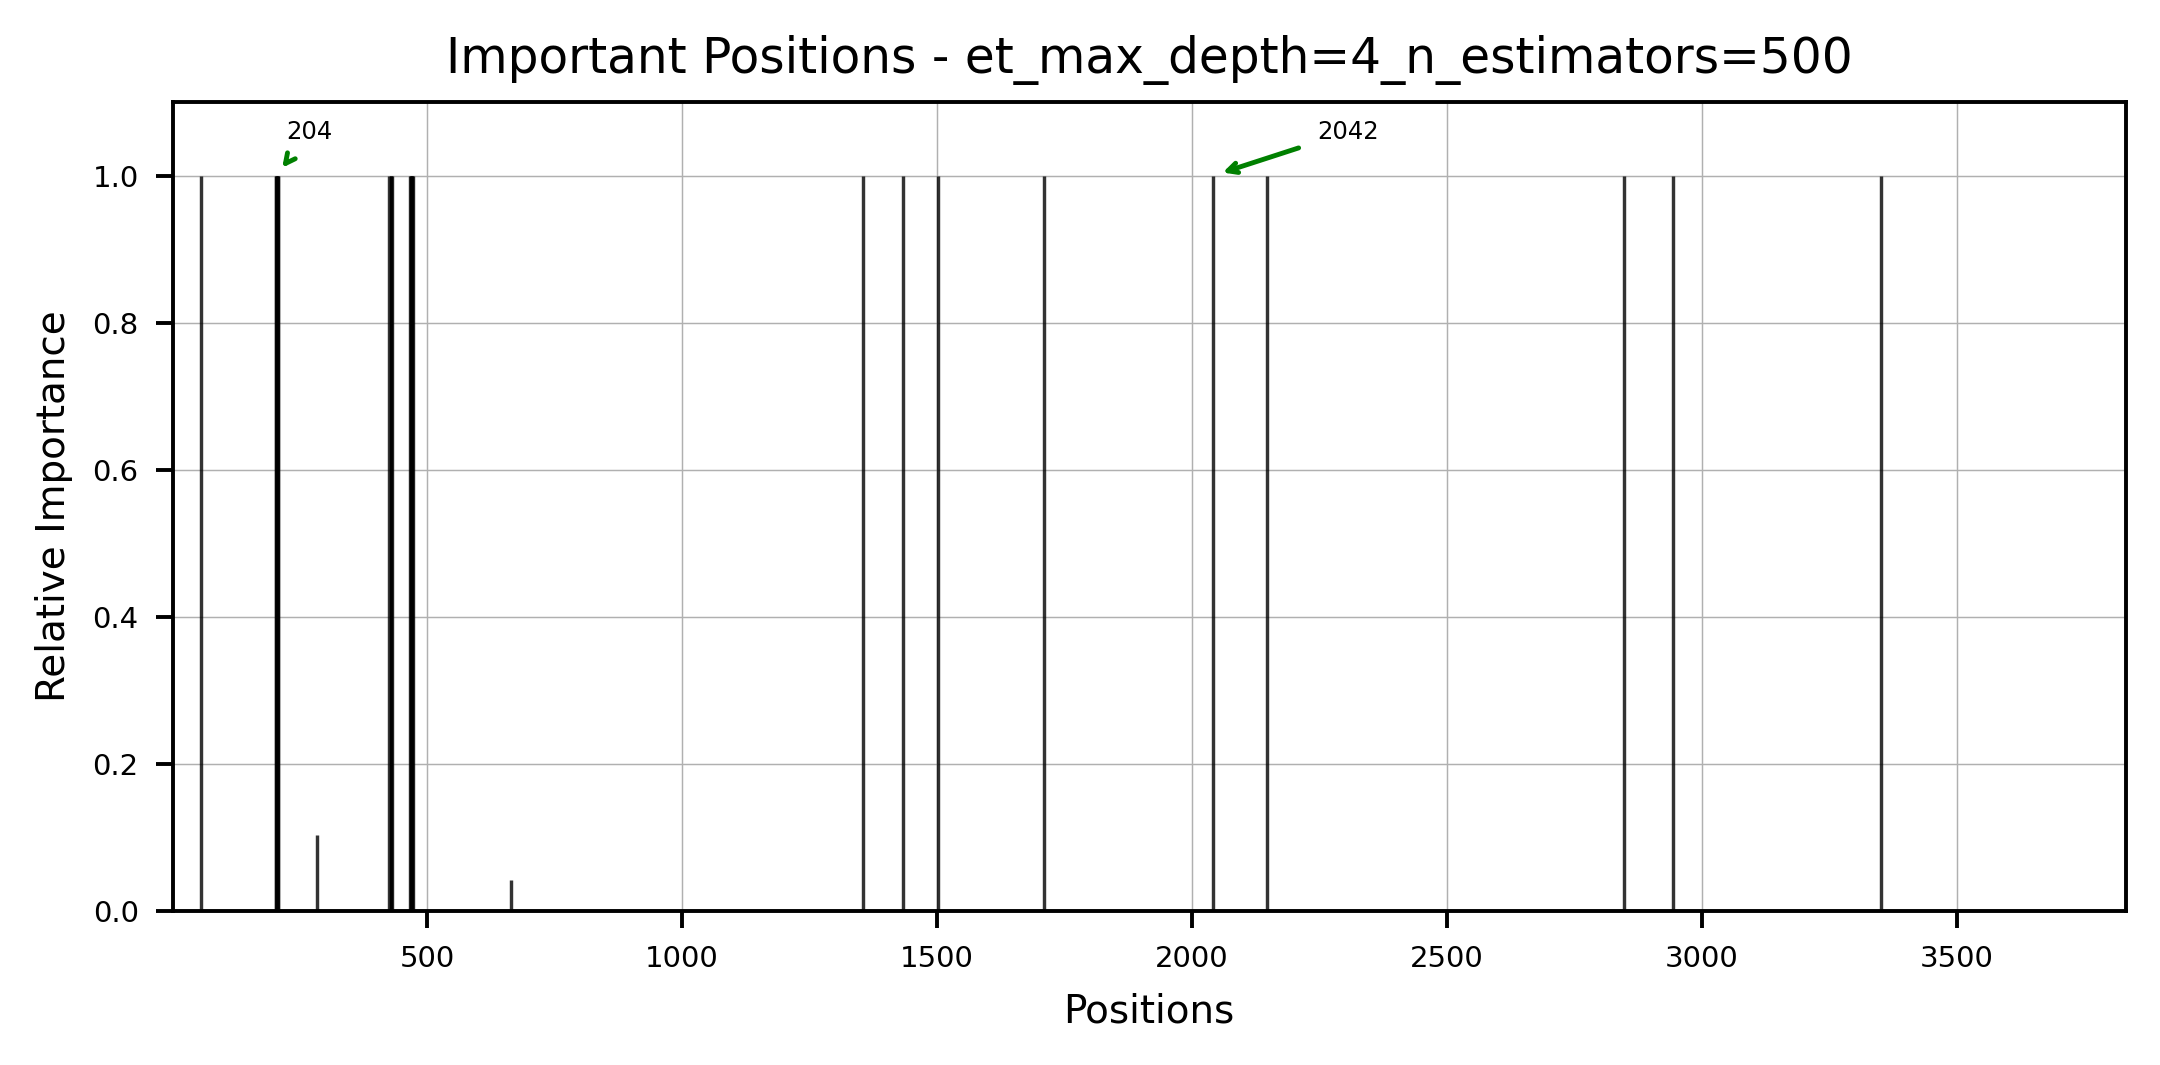

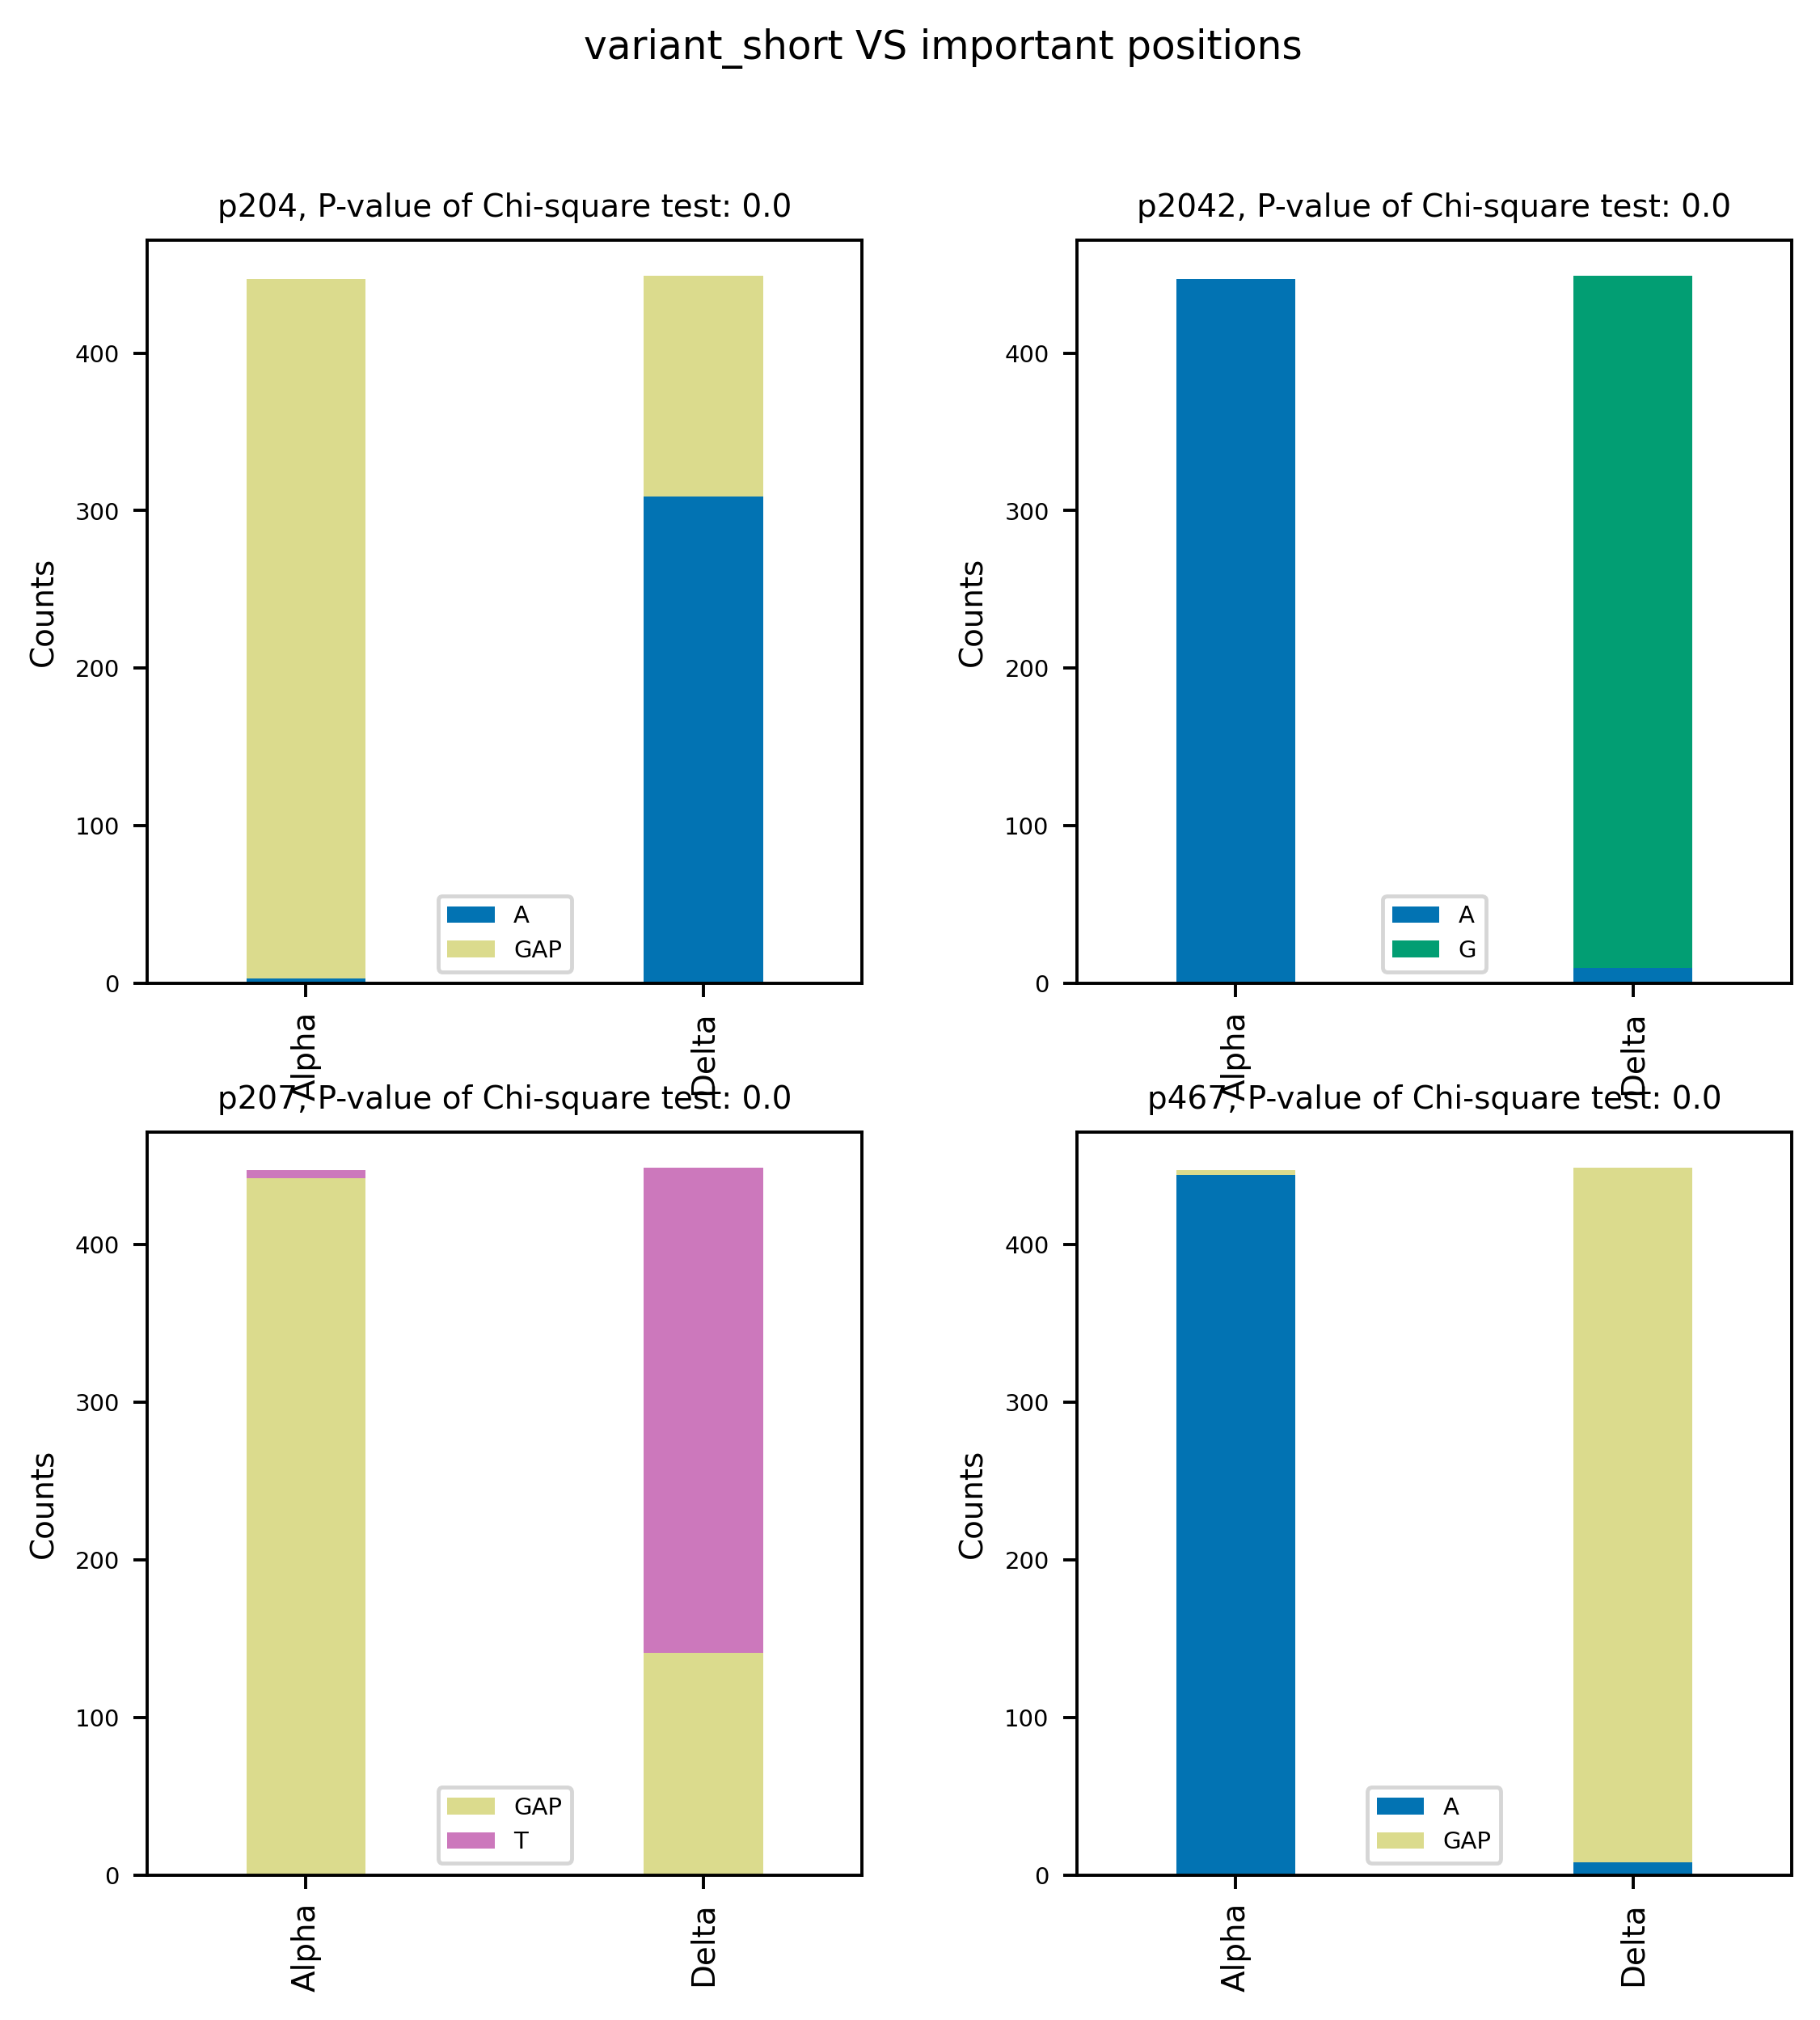

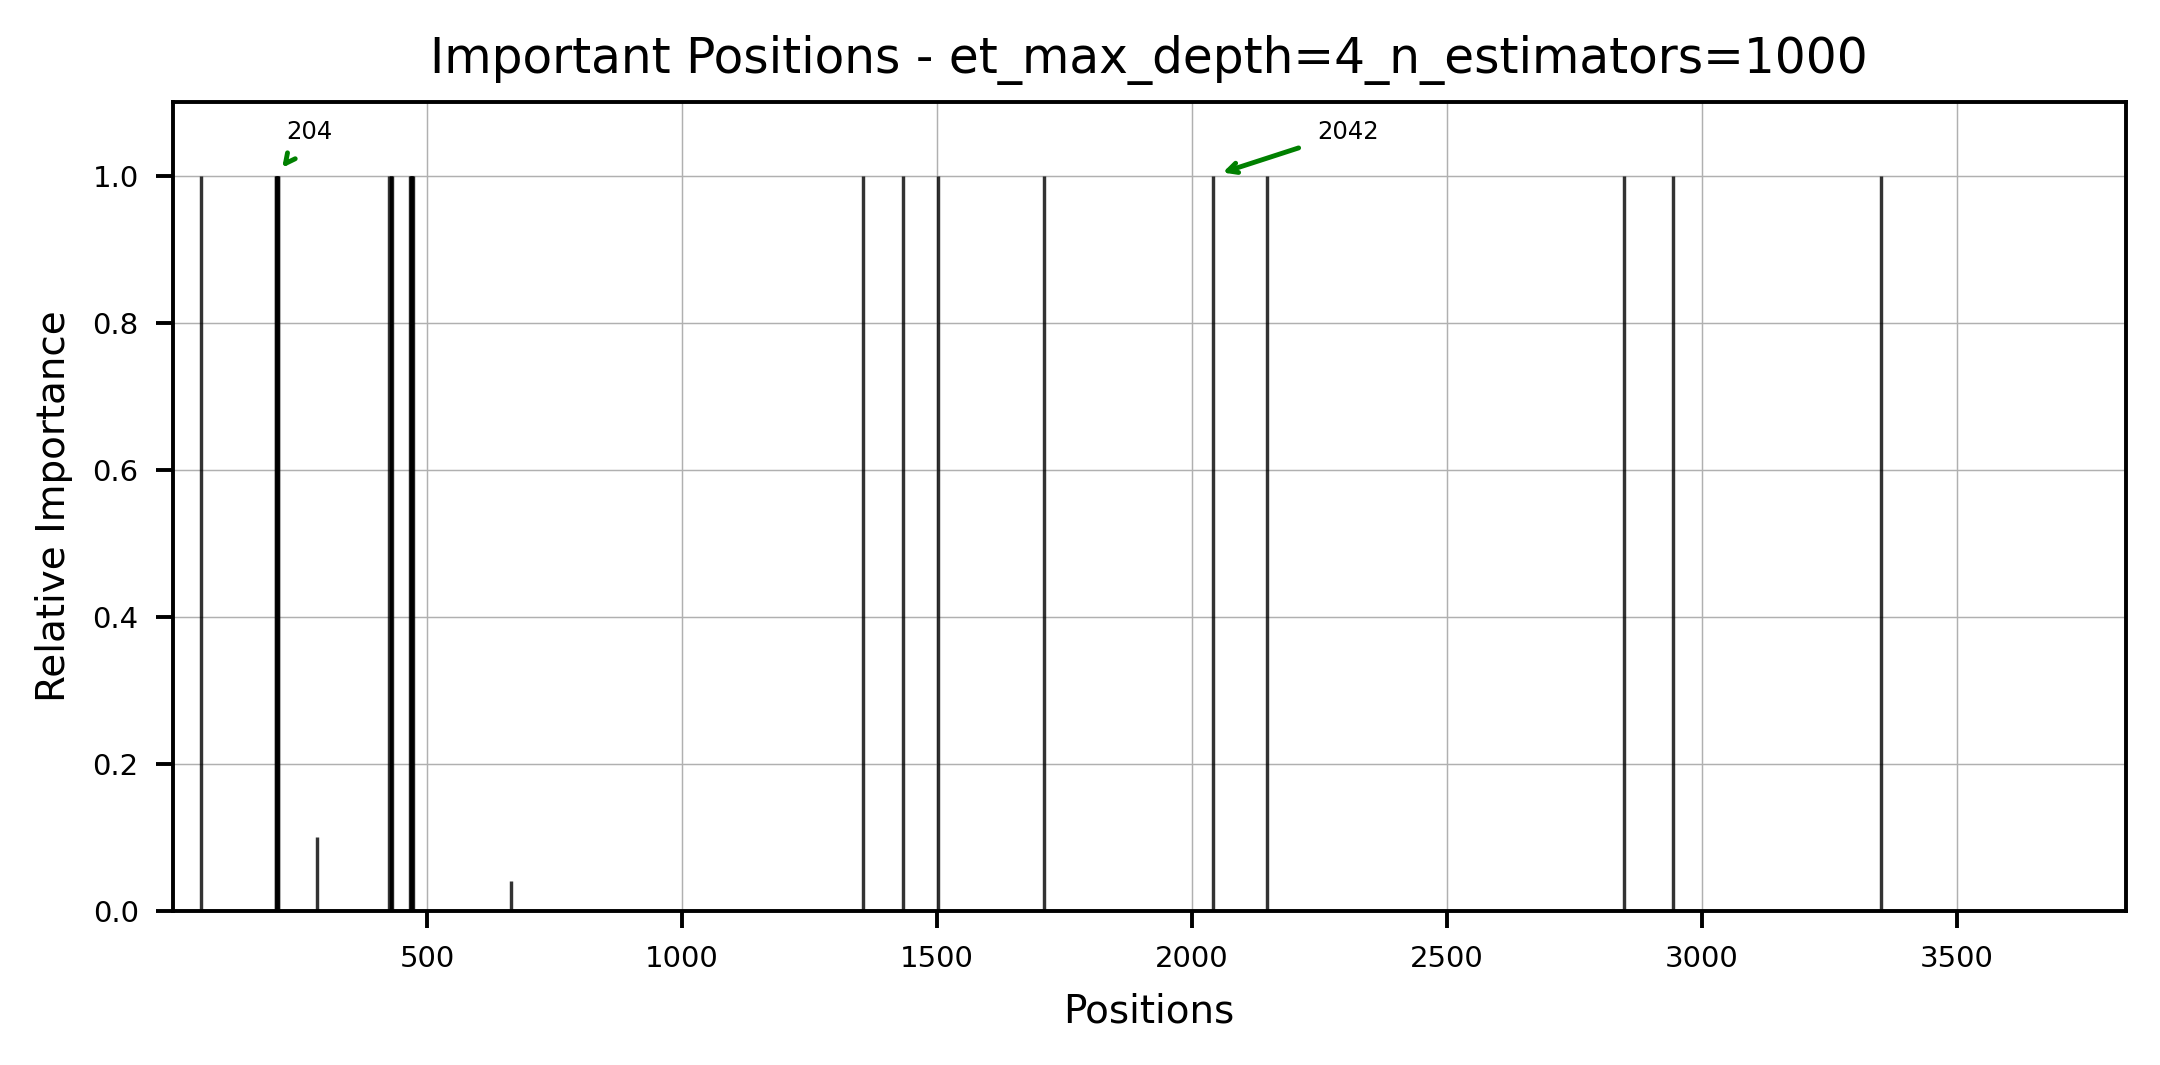

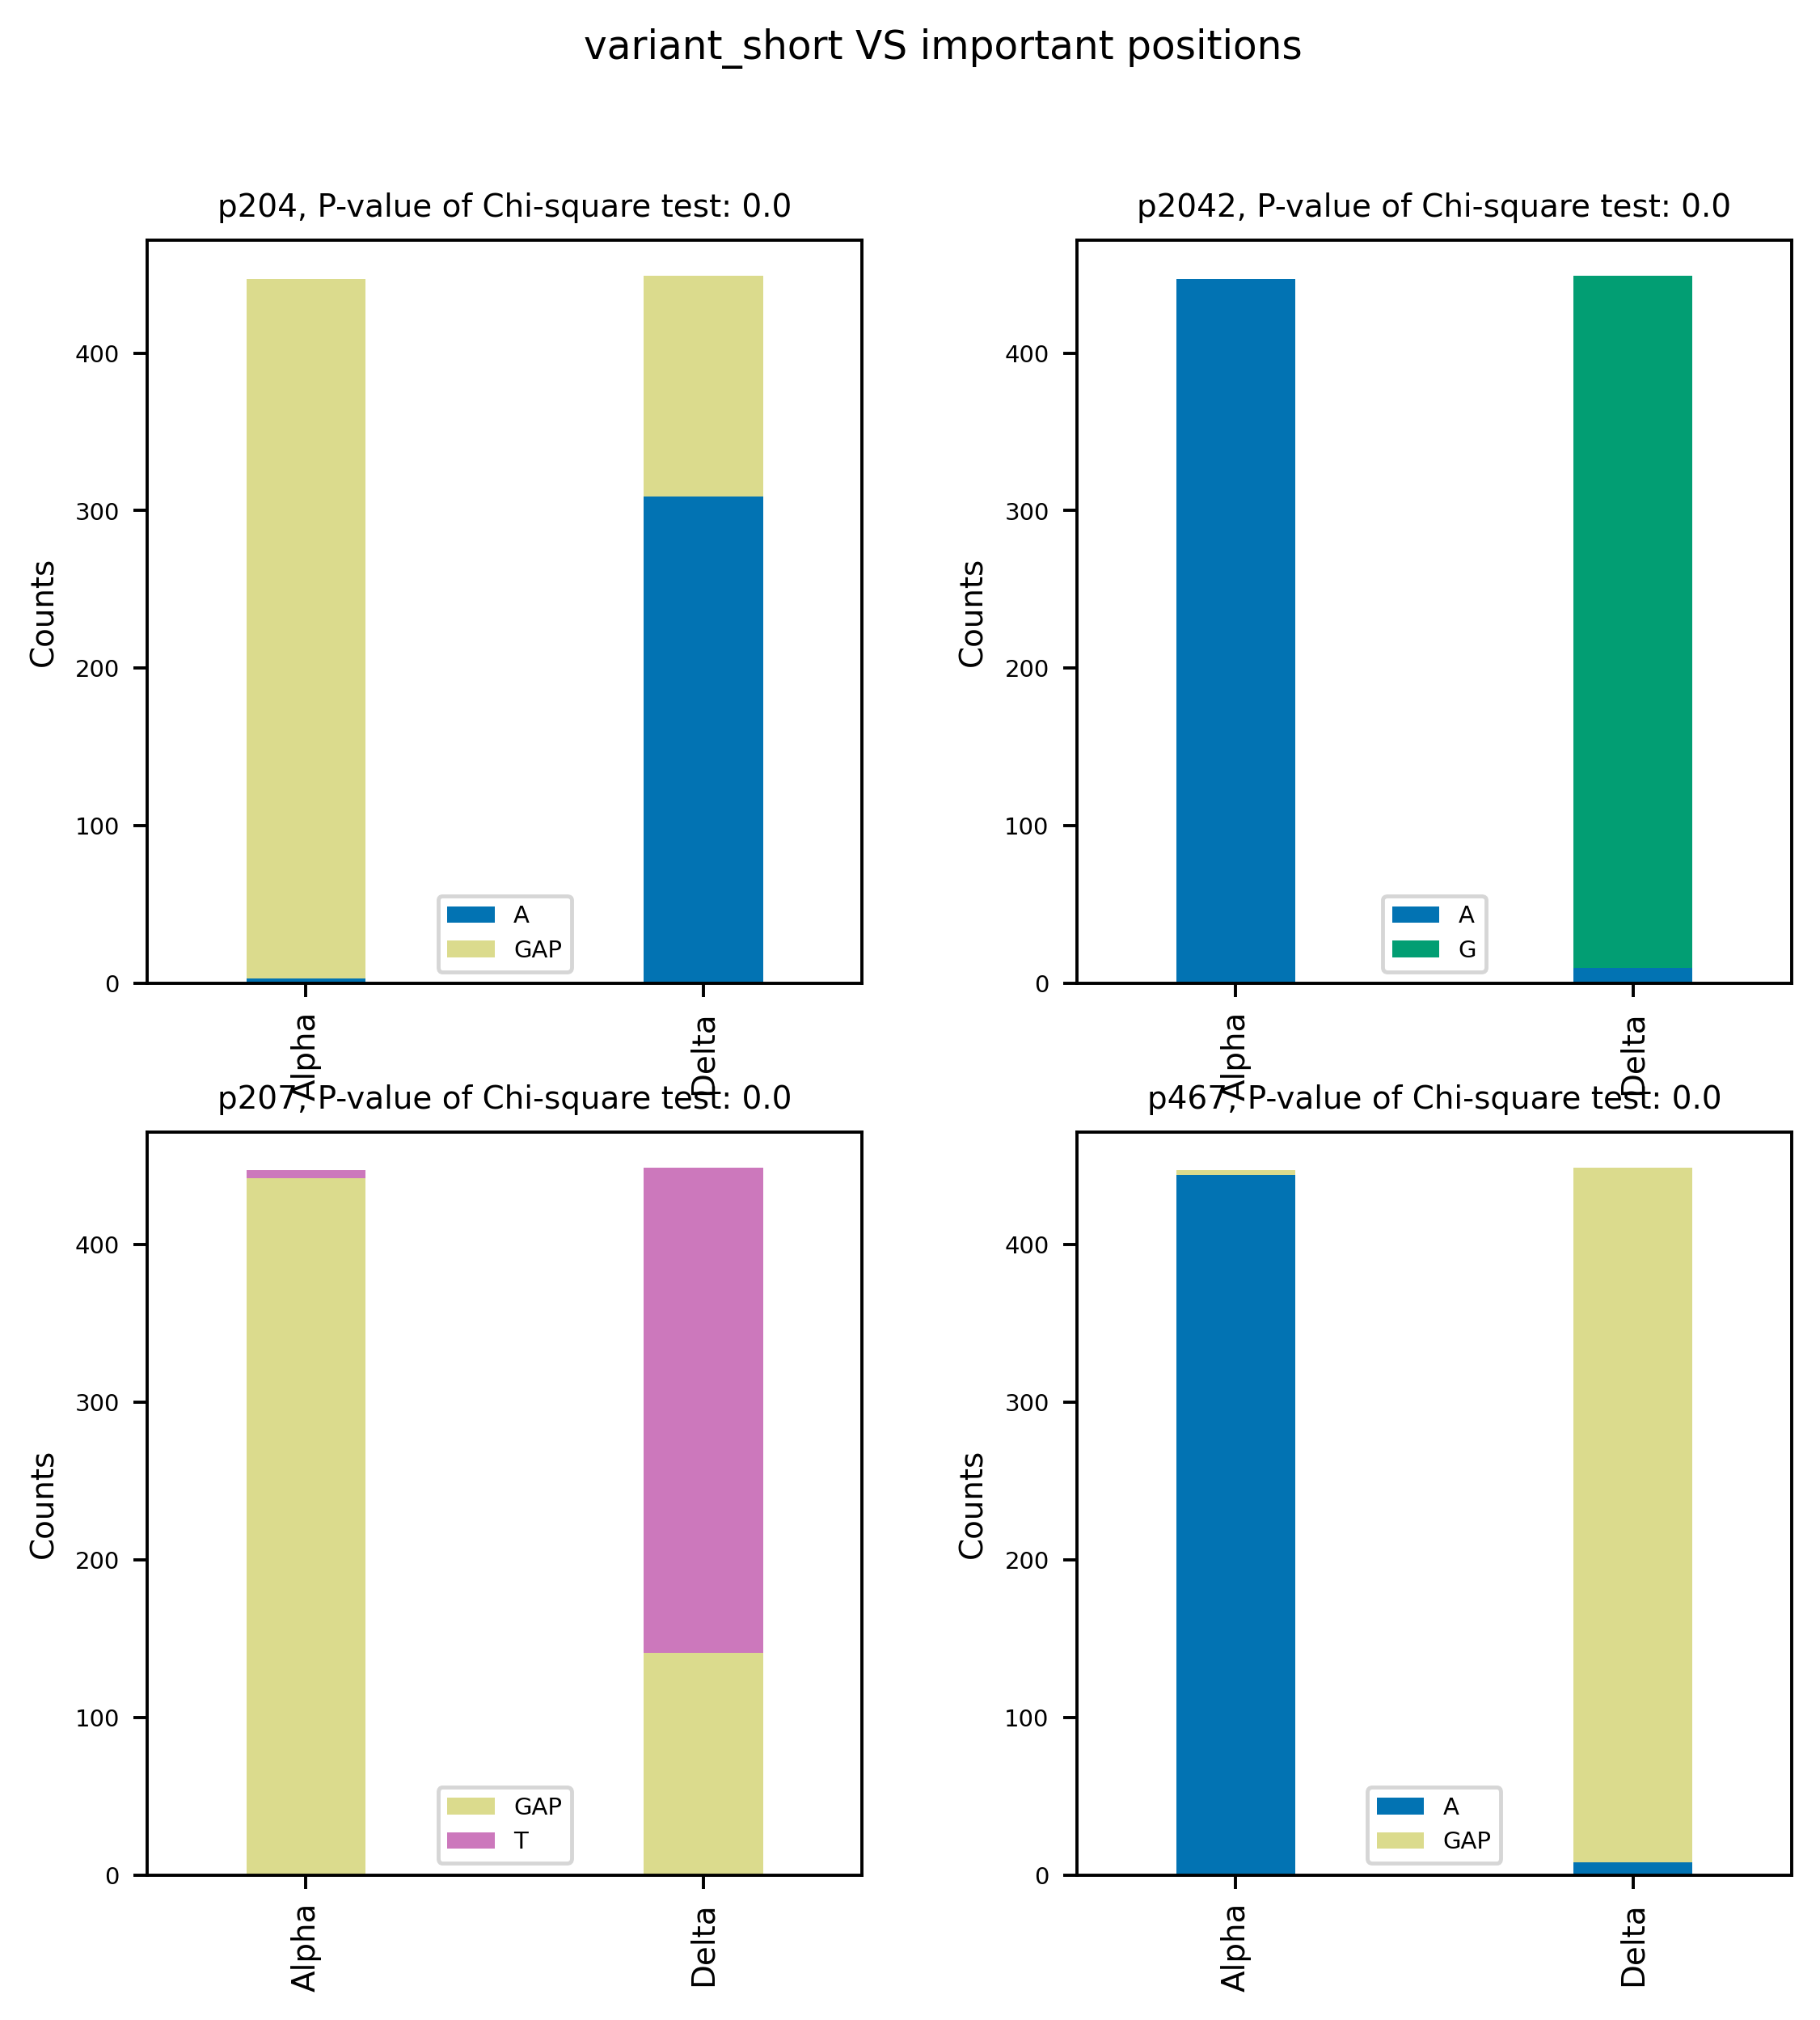

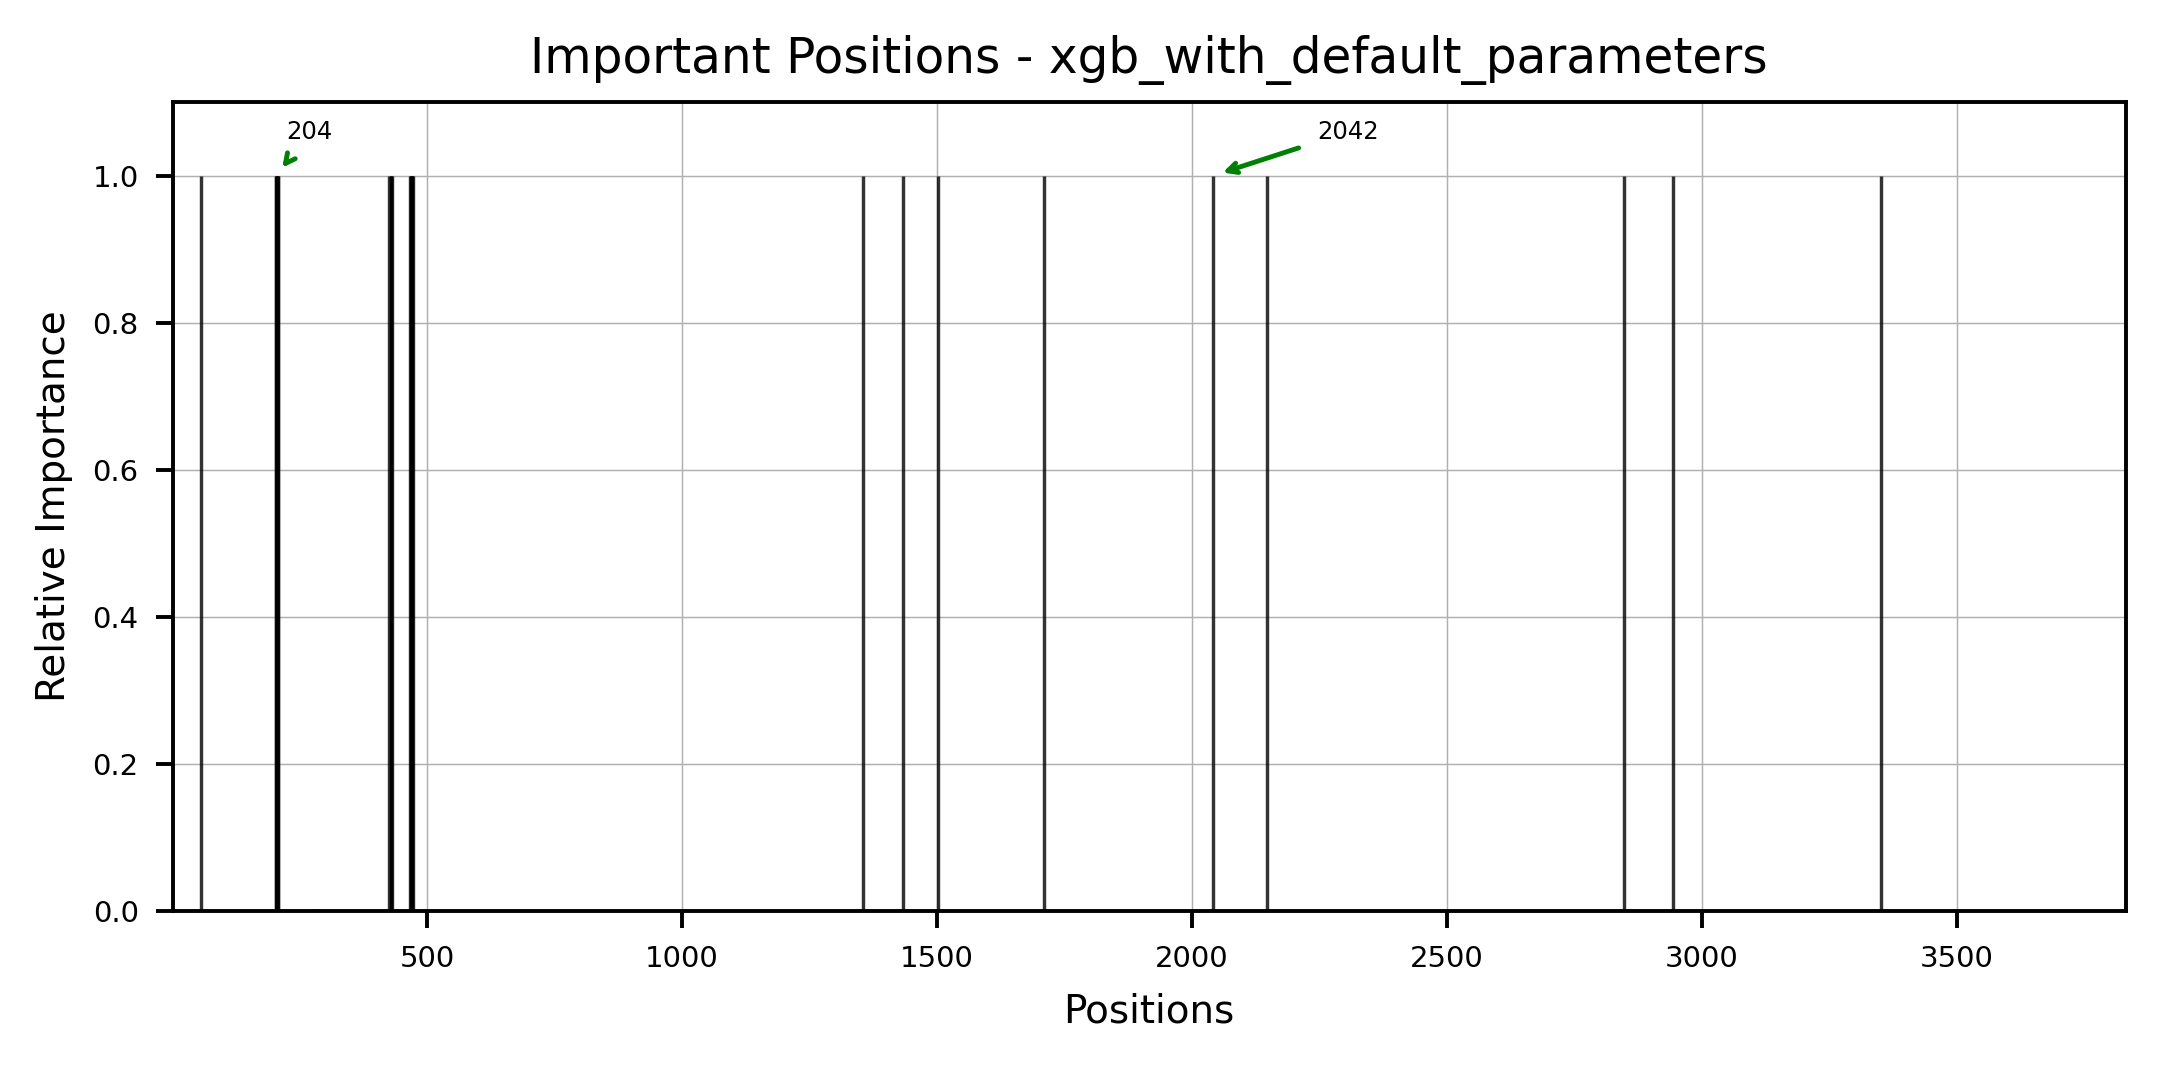

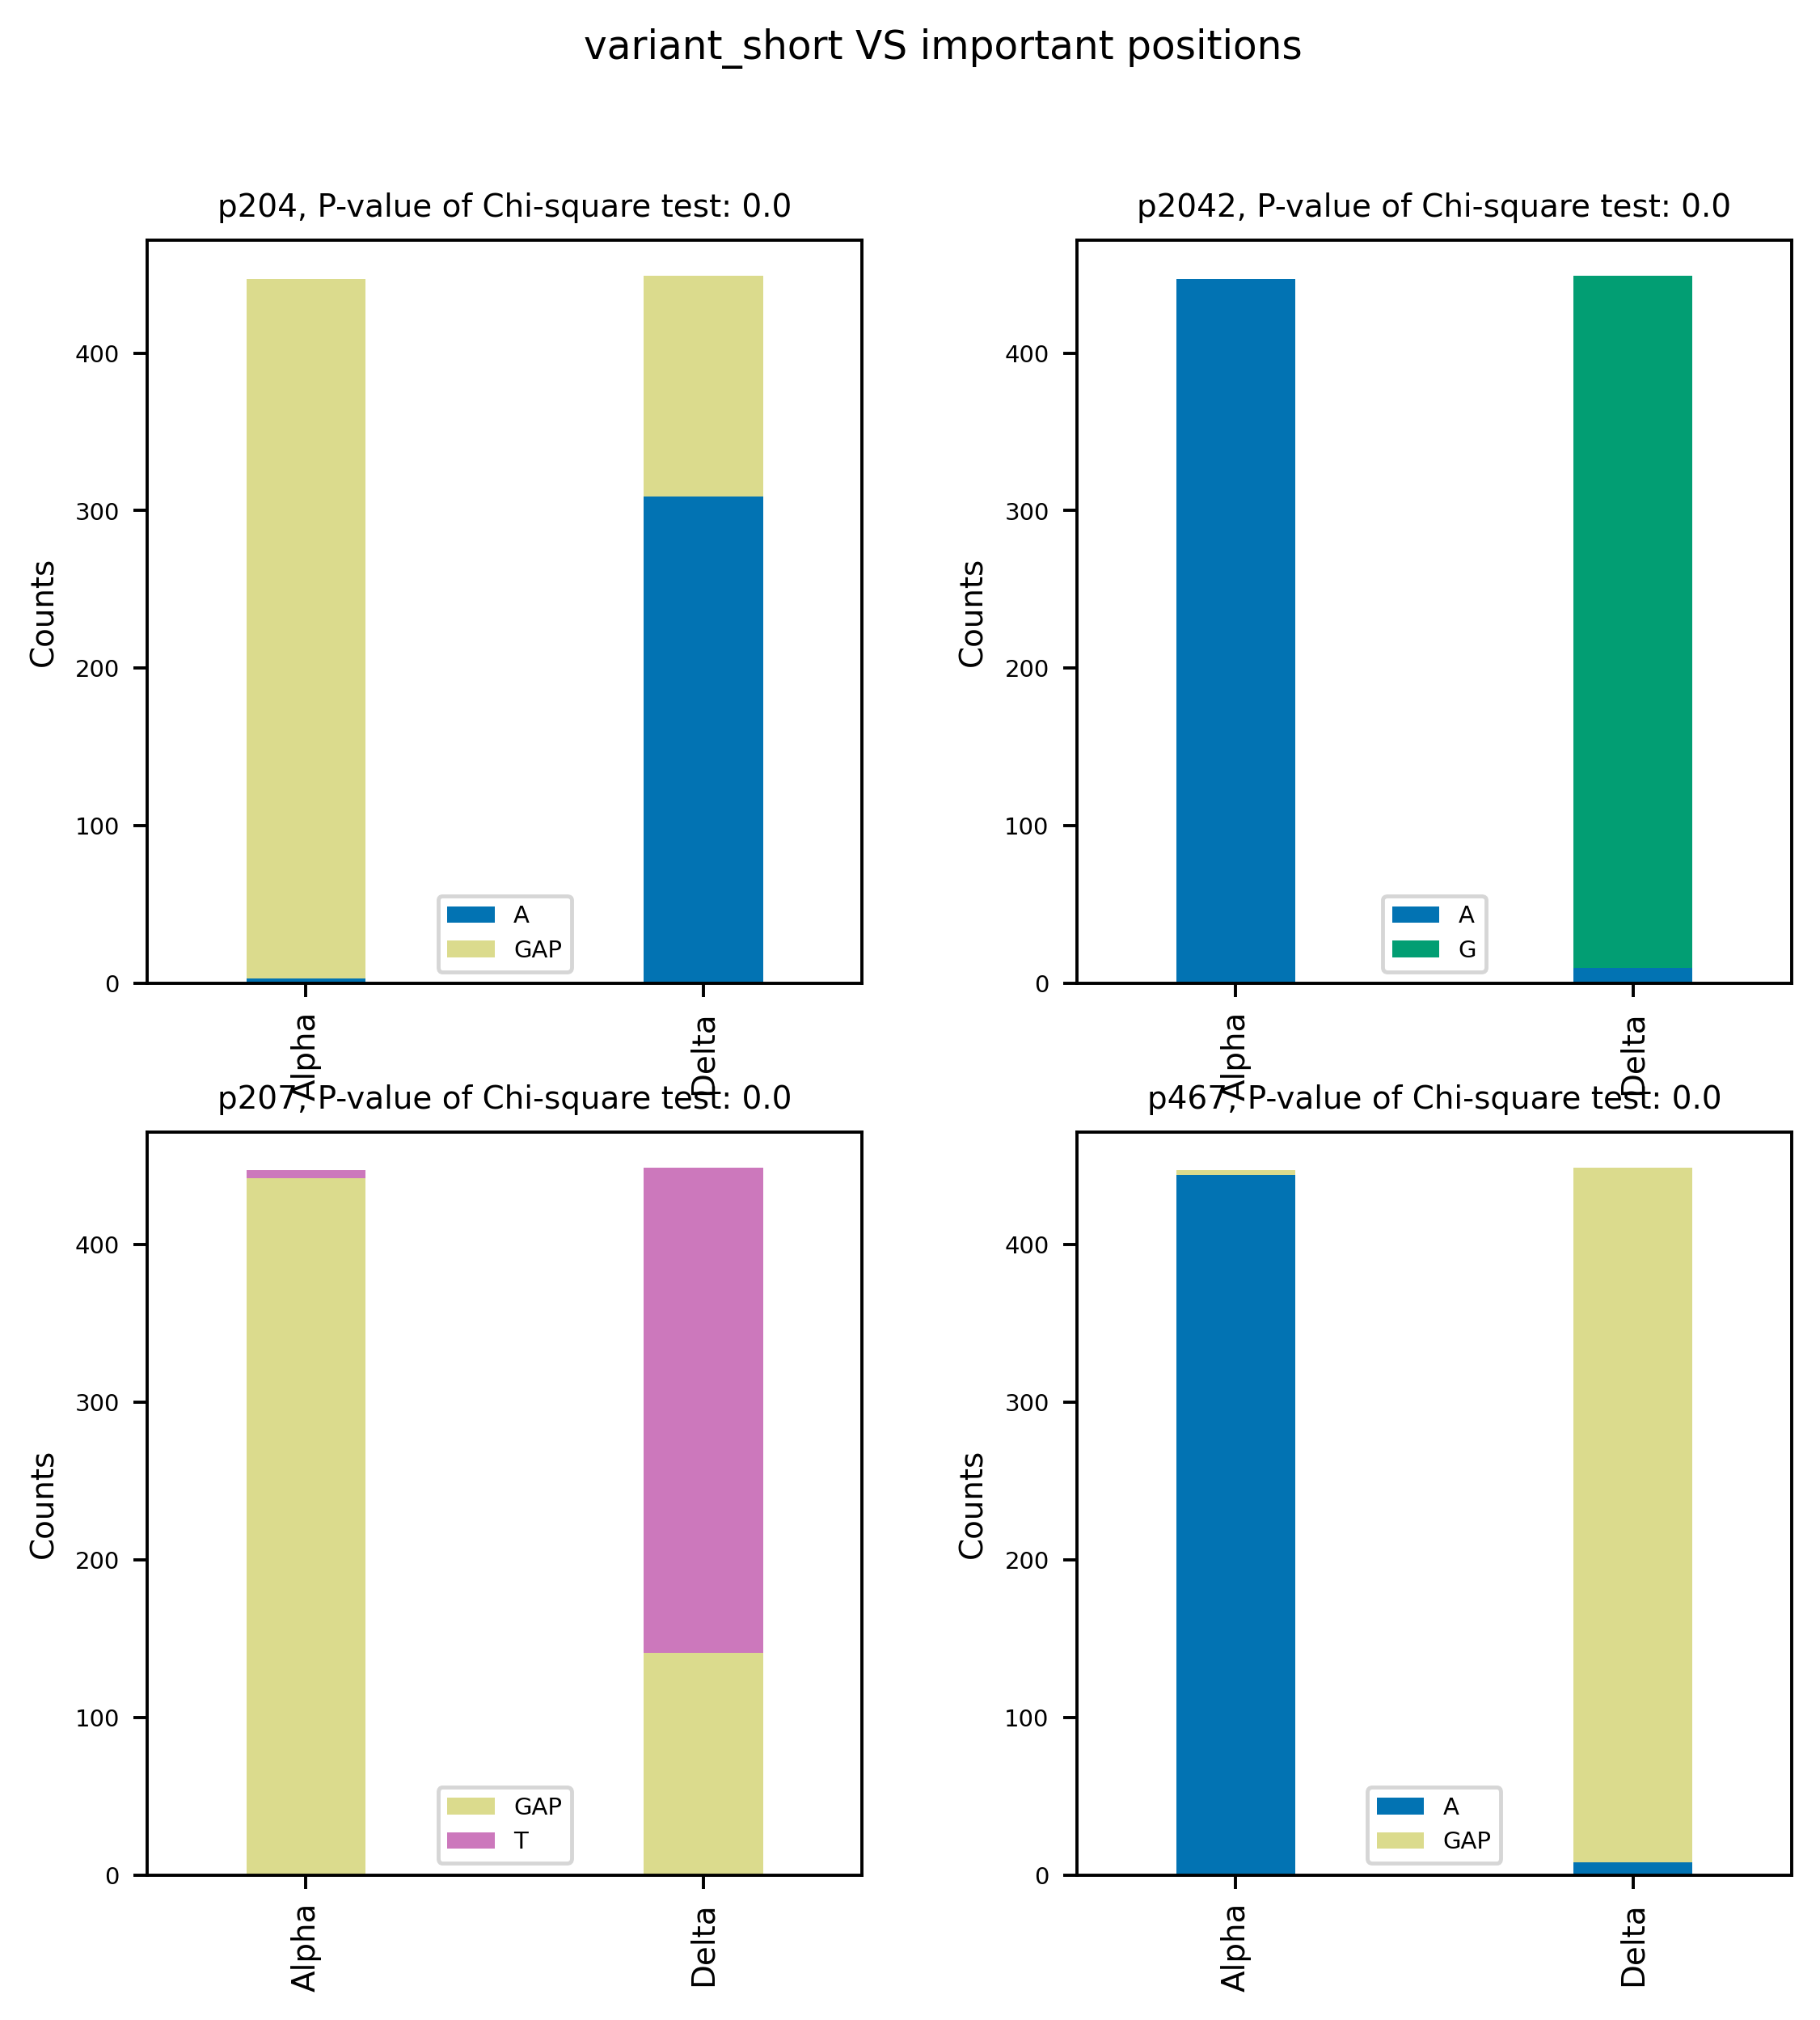

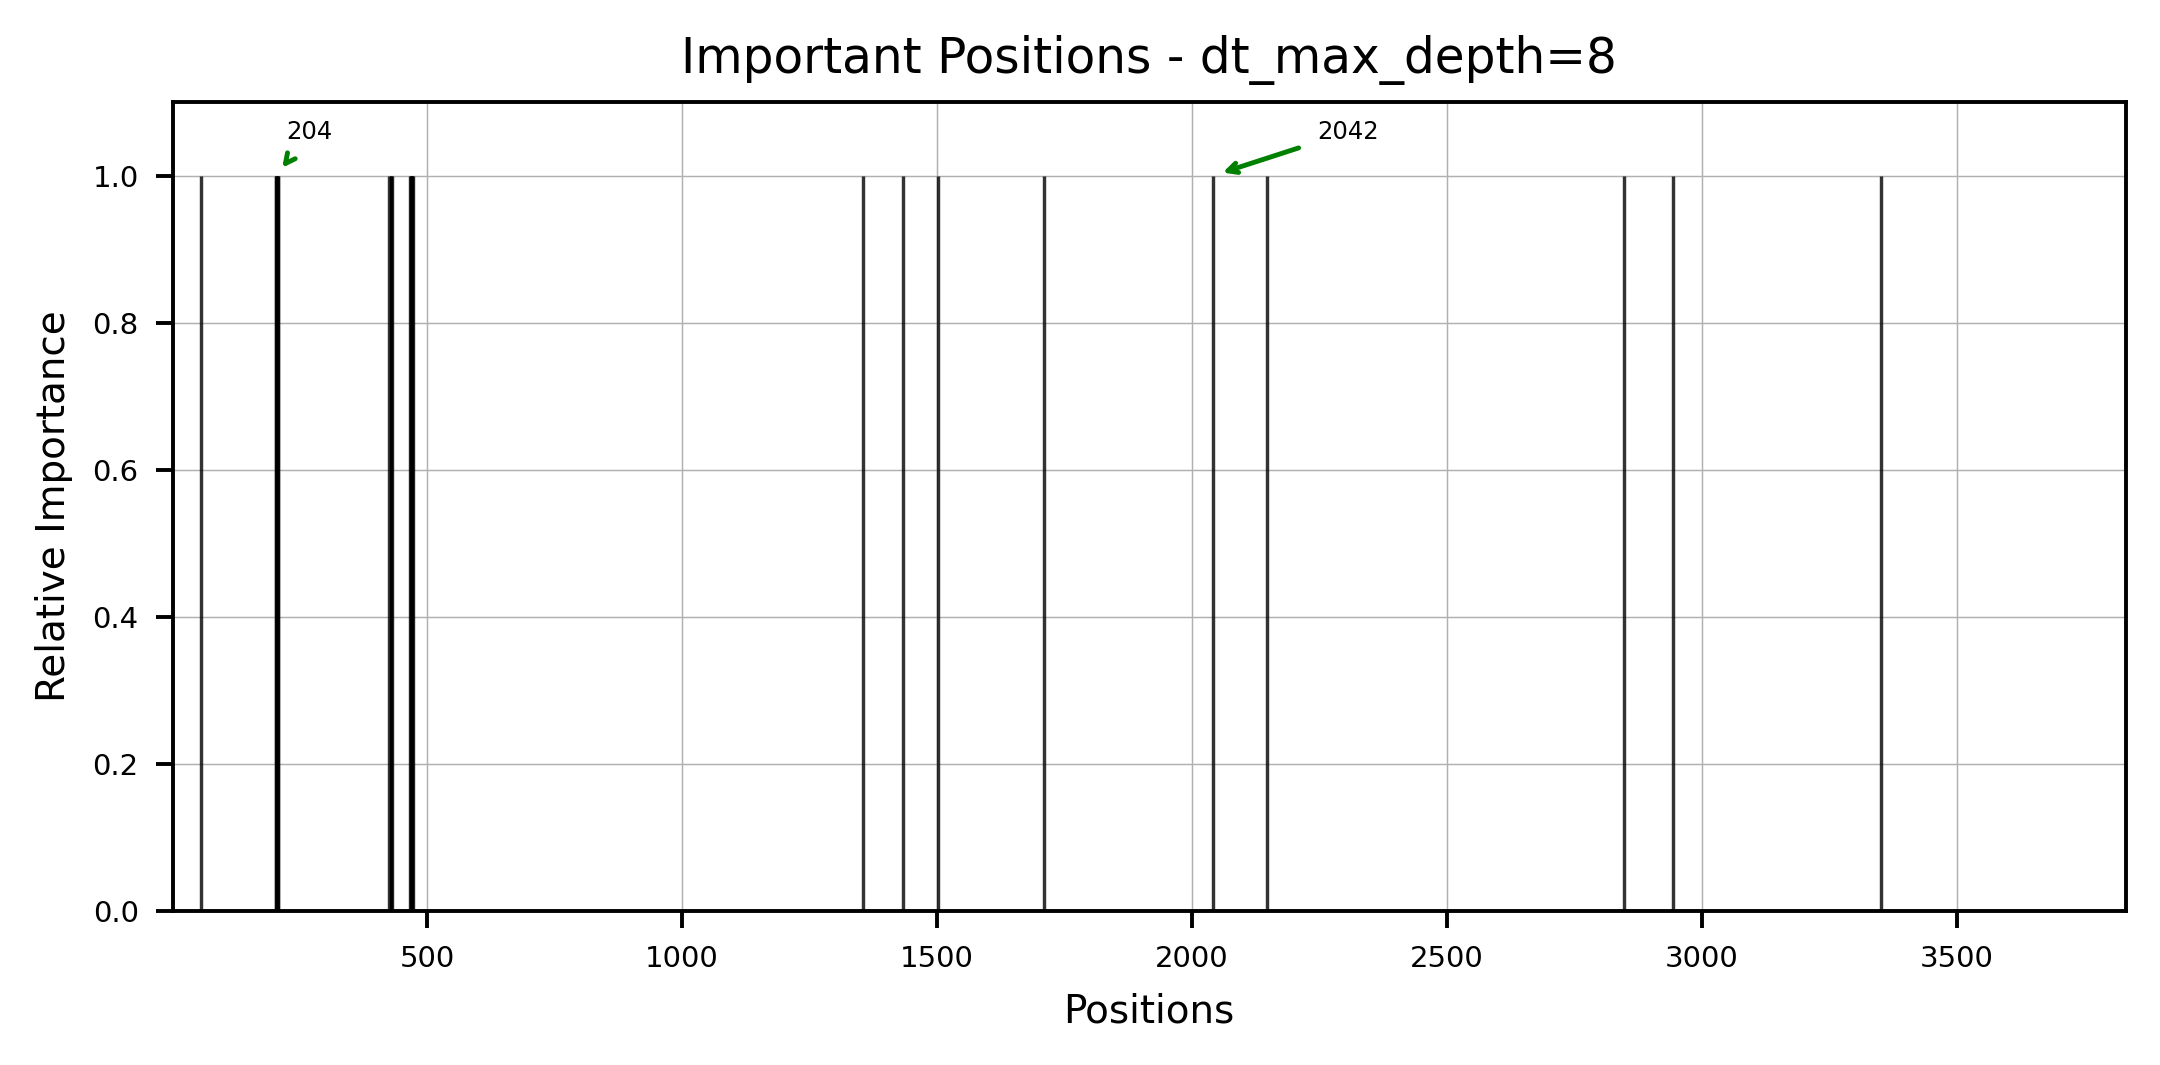

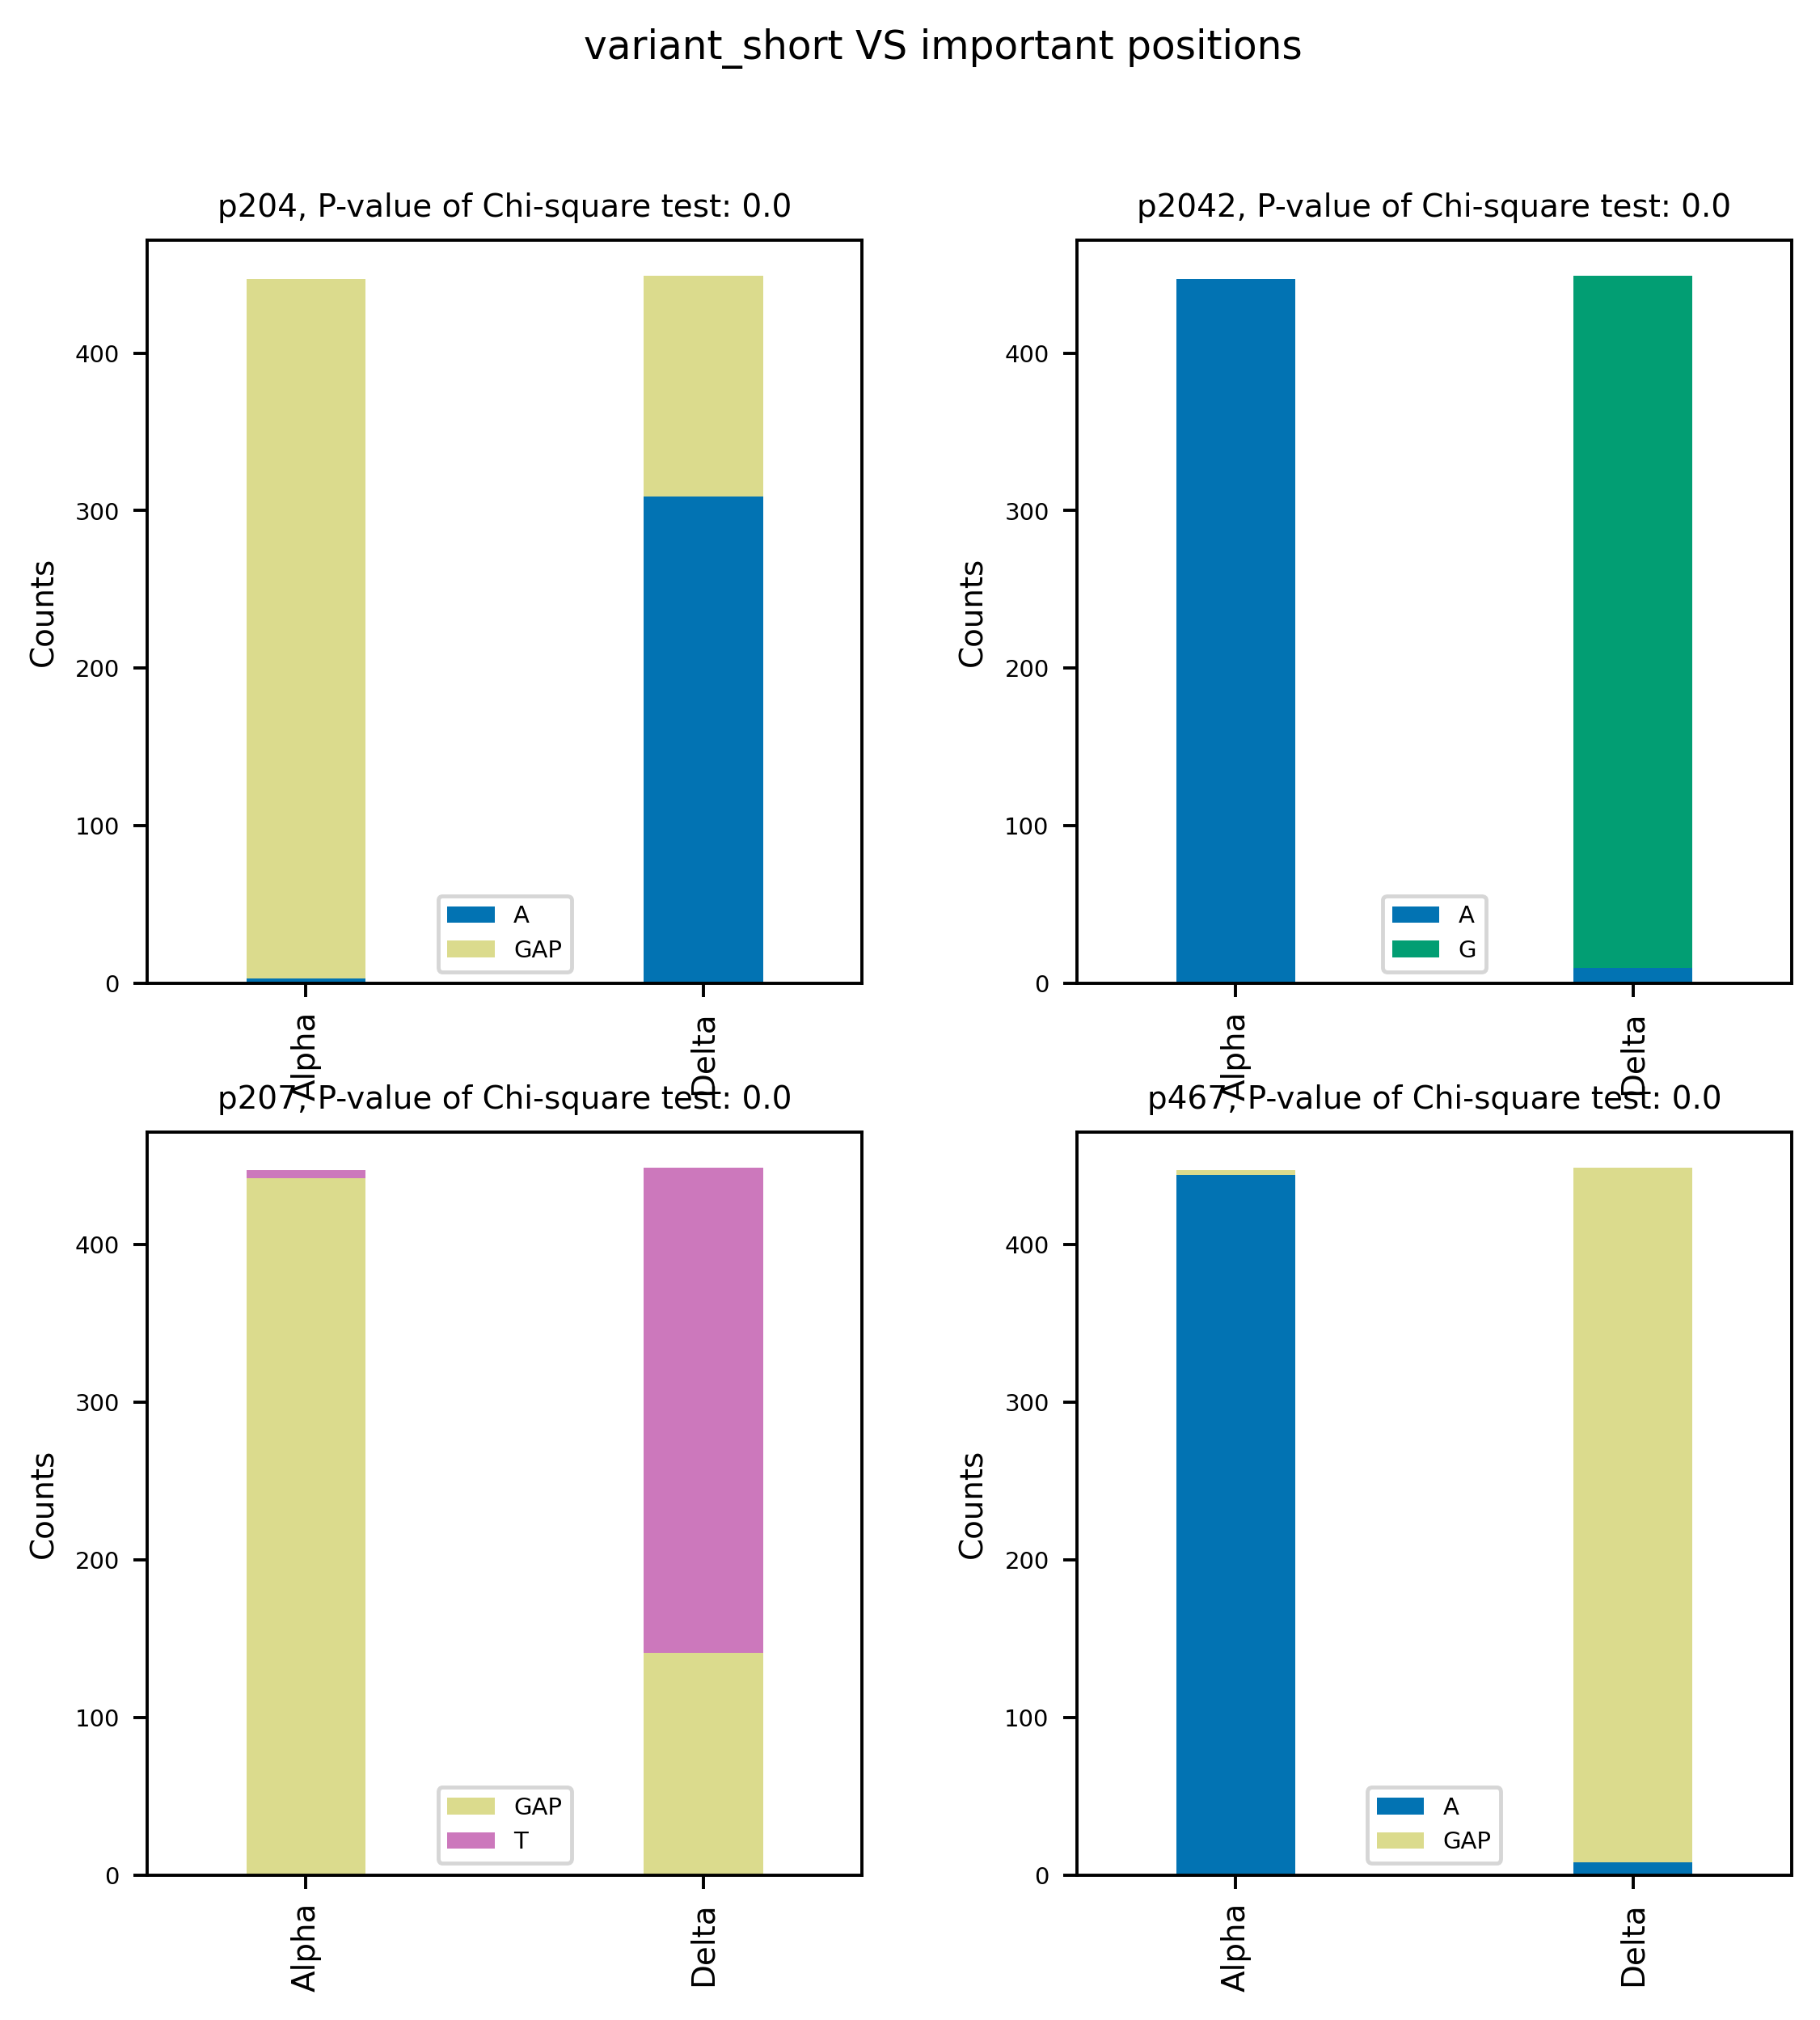

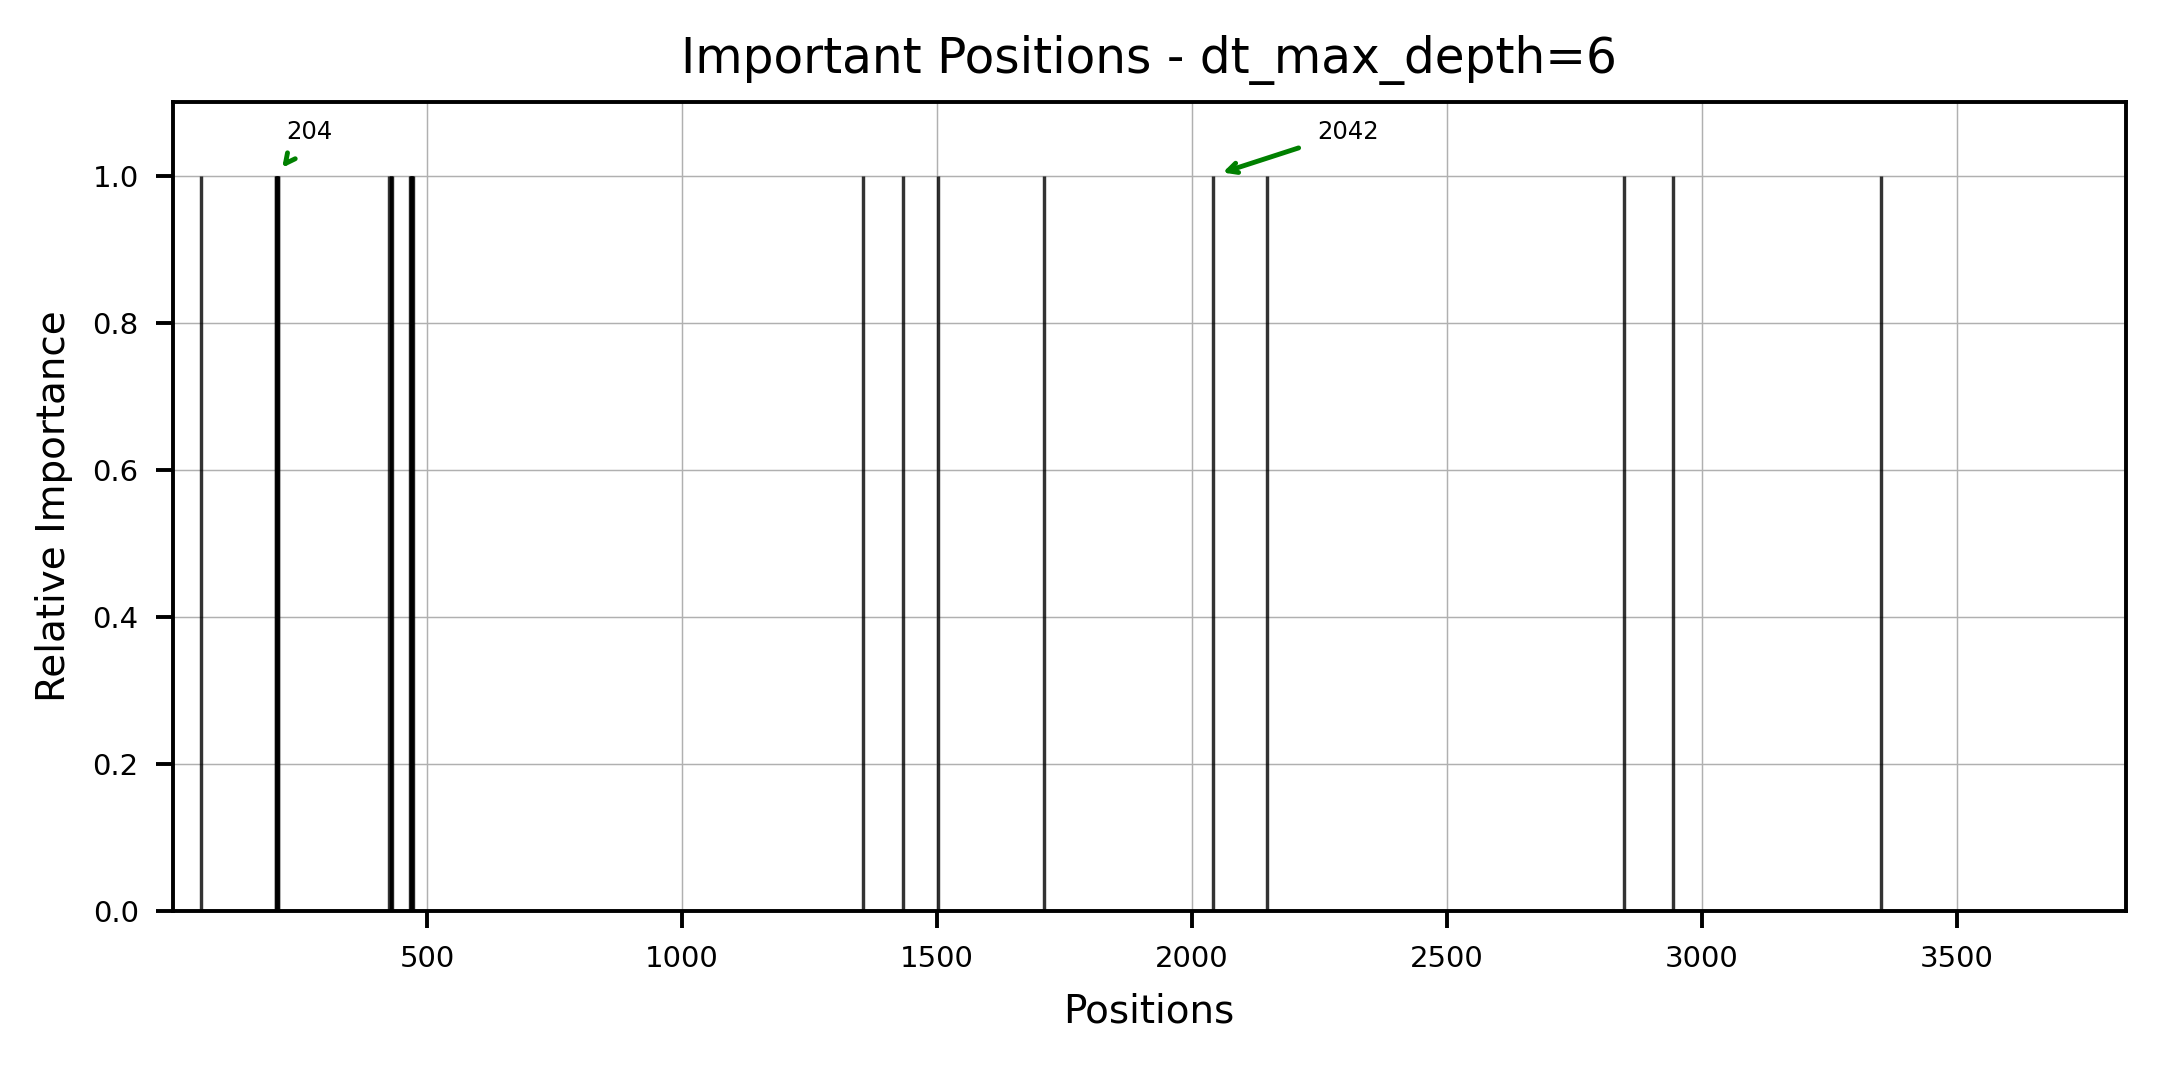

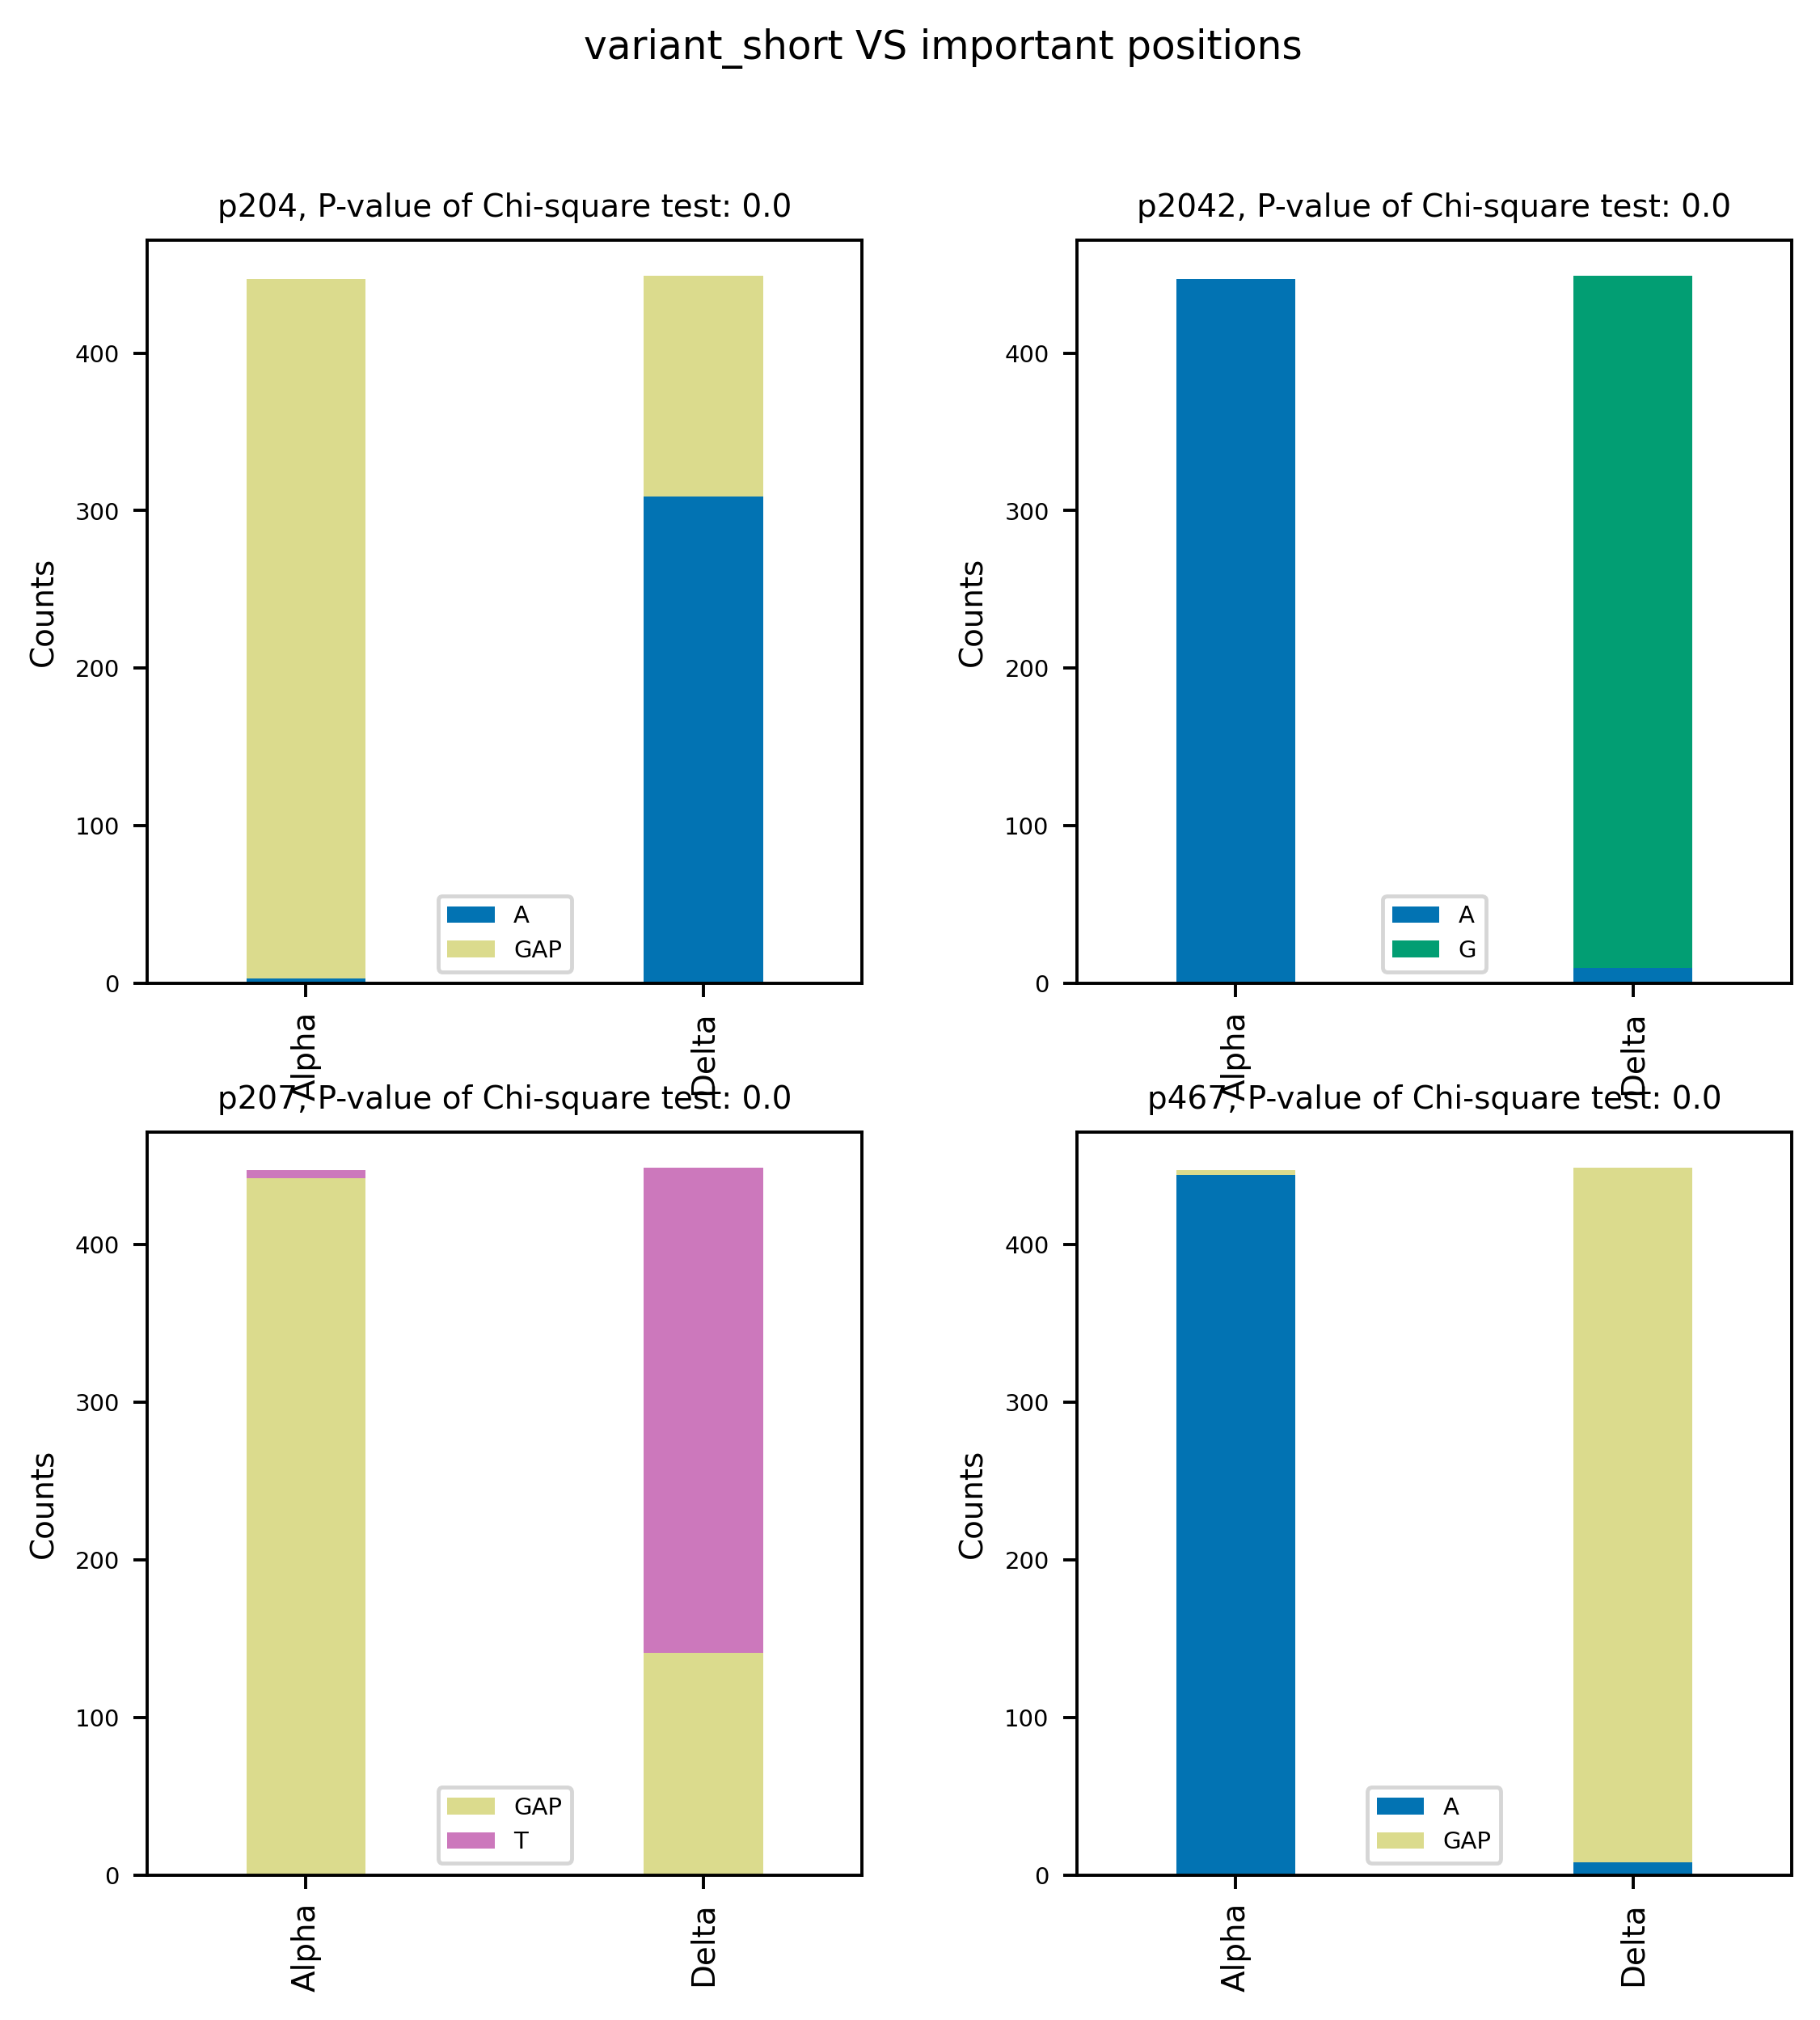

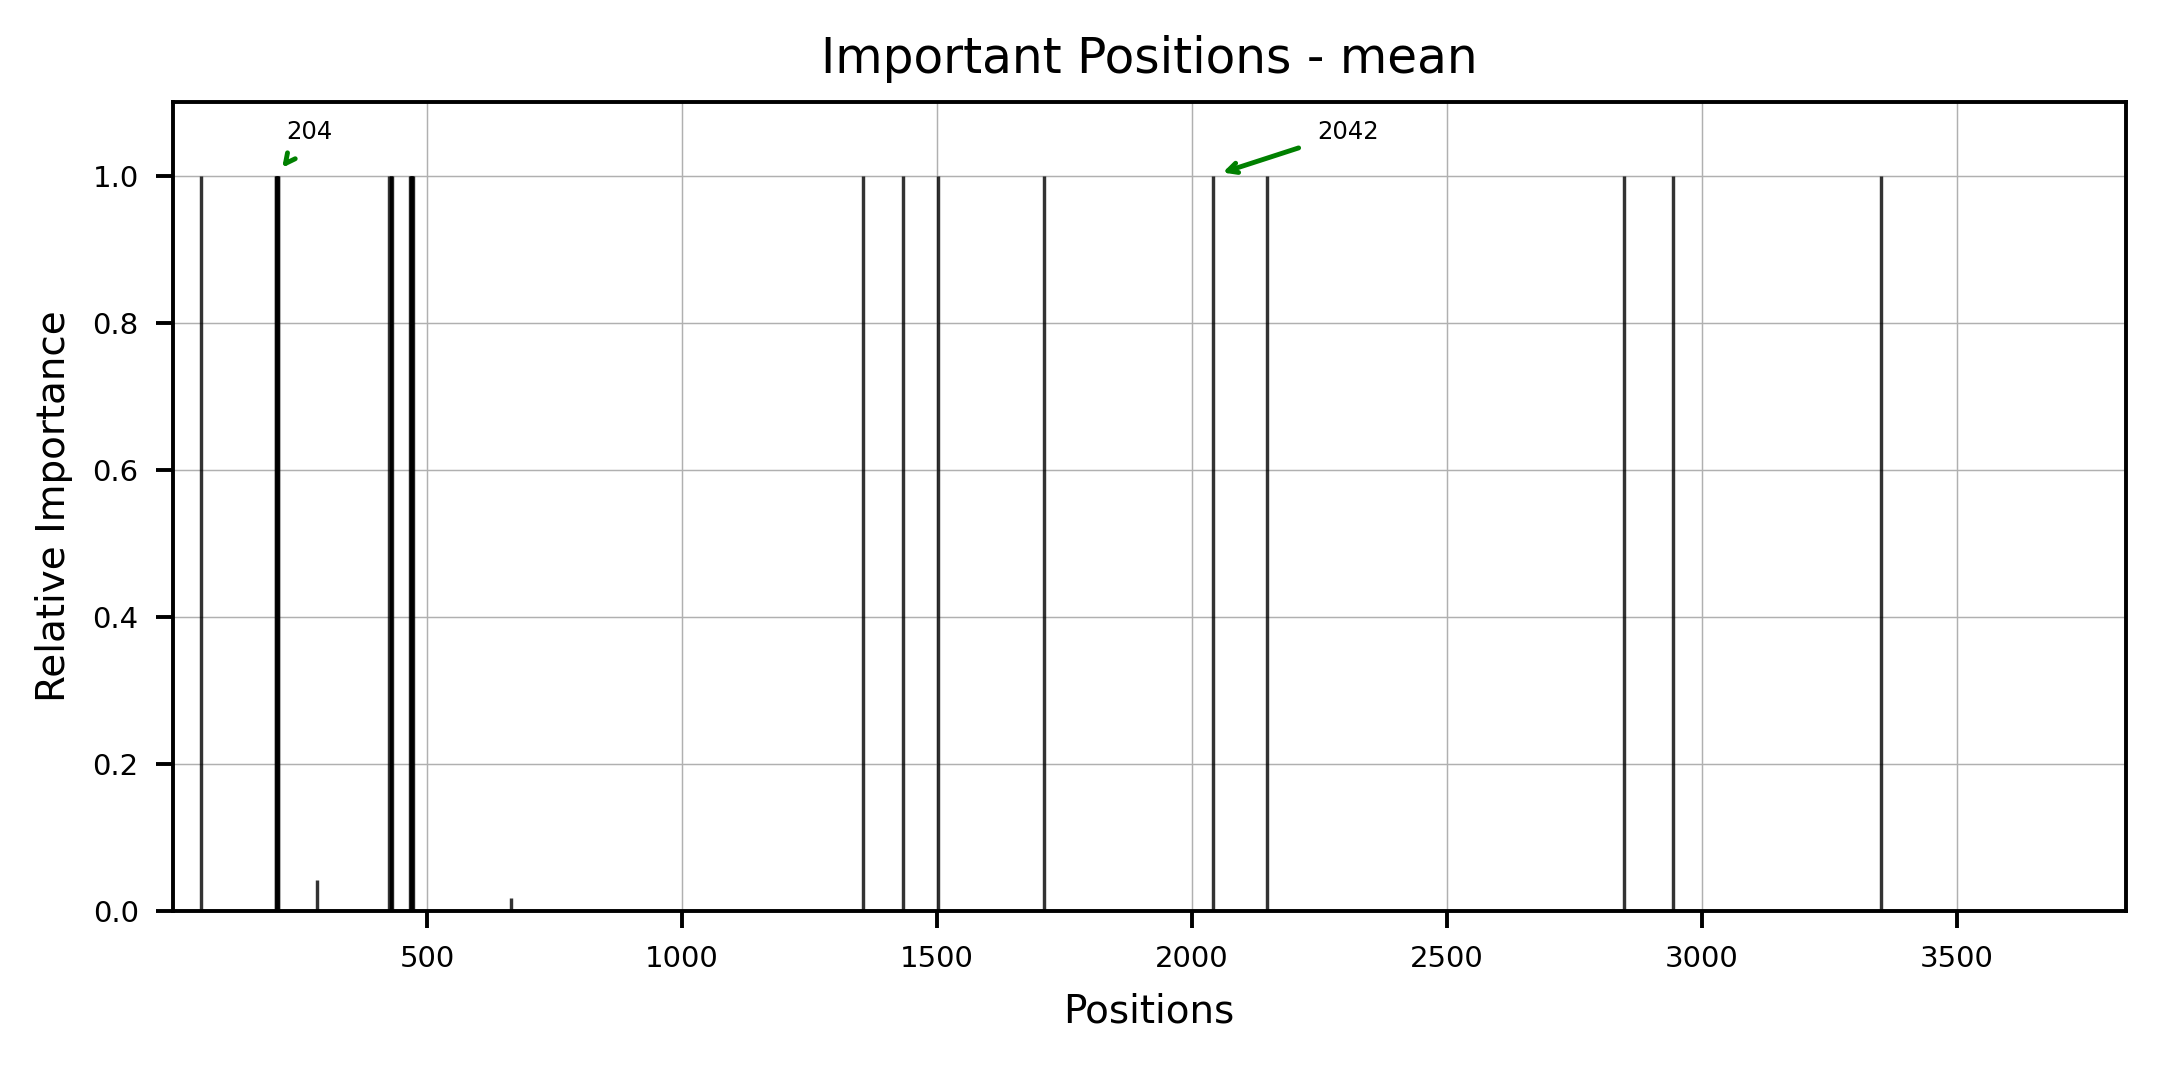

In [49]:
for key in trained_models.keys():
    if key == 'mean':
        # plot the mean importance
        viz.dp_plot(importance=trained_models[key], imp_col='mean', model_name=key, annotate=2, report_dir=report_dir)
    else:
        # importance plot (barplot)
        viz.dp_plot(importance= trained_models[key]['importance'], imp_col='standard_value', 
                model_name=key, annotate=2,report_dir=report_dir)
        # top 4 position from each model
        viz.plot_imp_model(importance=trained_models[key]['importance'],
                           X_train=df.loc[:, df.columns != mt],
                           y_train=df.loc[:, mt],
                           model_name=key, meta_var=mt, model_type=anaType,
                           report_dir=report_dir)

<span style="color:red">**Running the next cell will produce individual plots for all of the positions in you sequence.**</span>

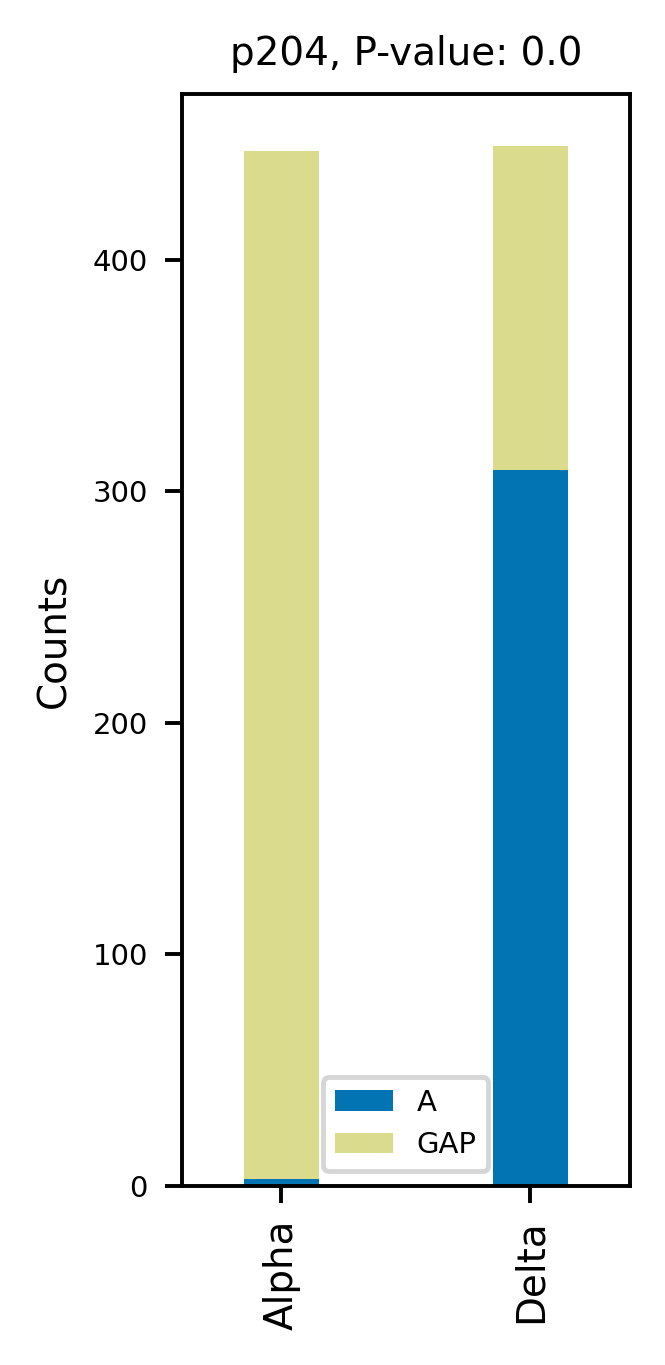

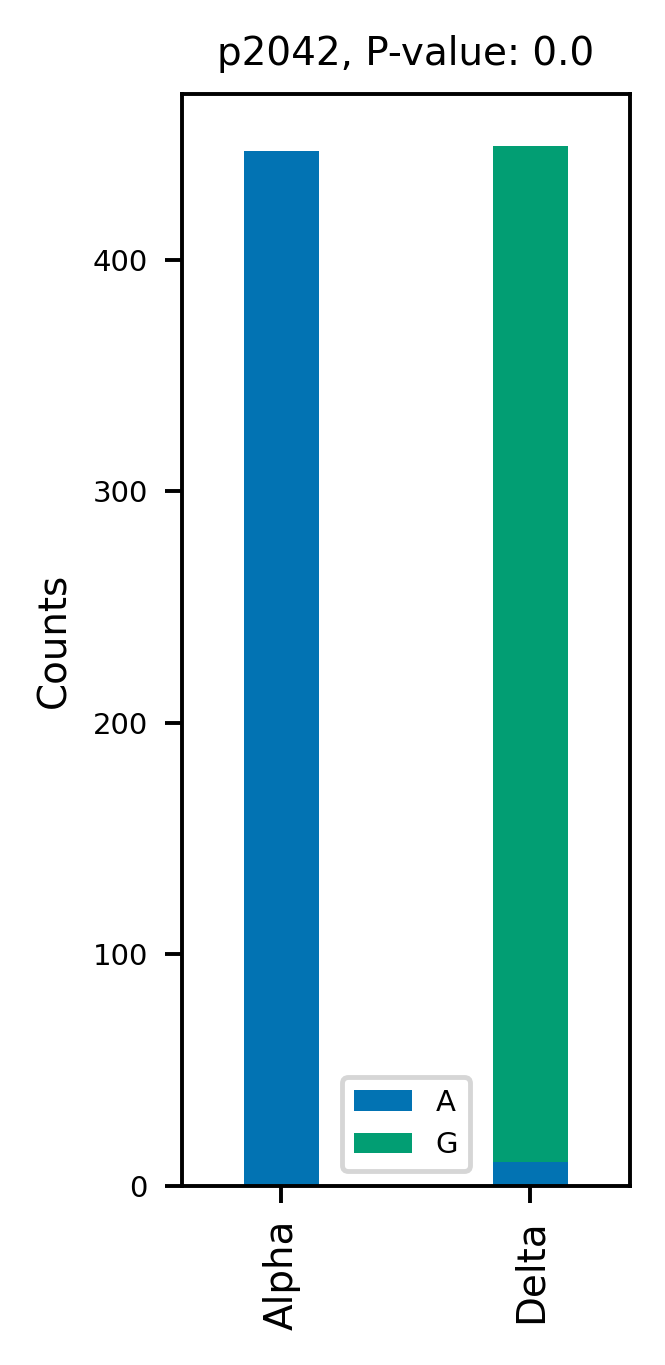

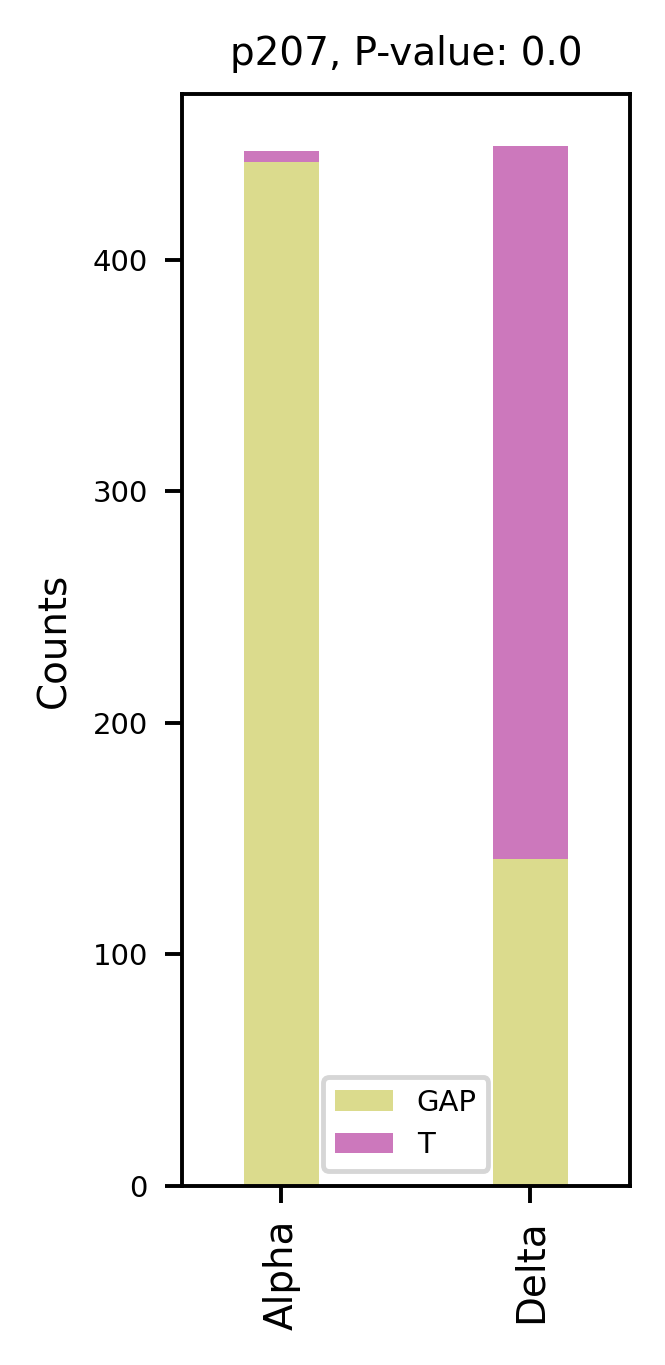

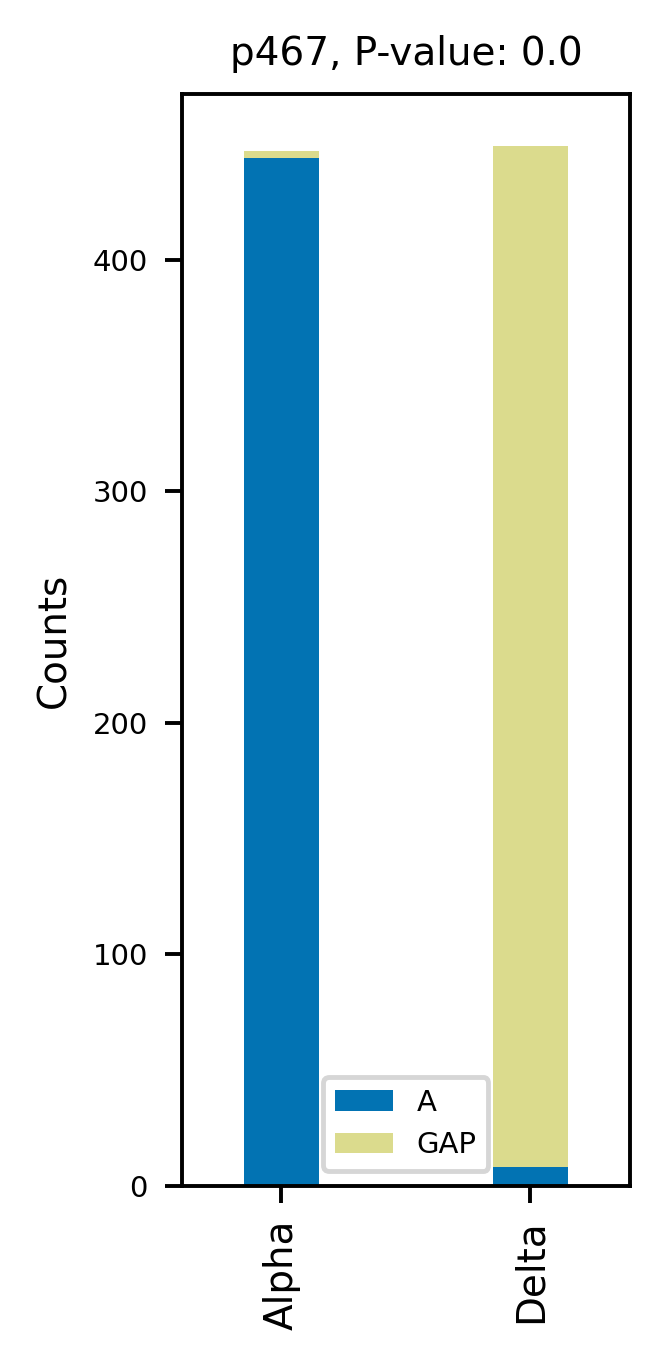

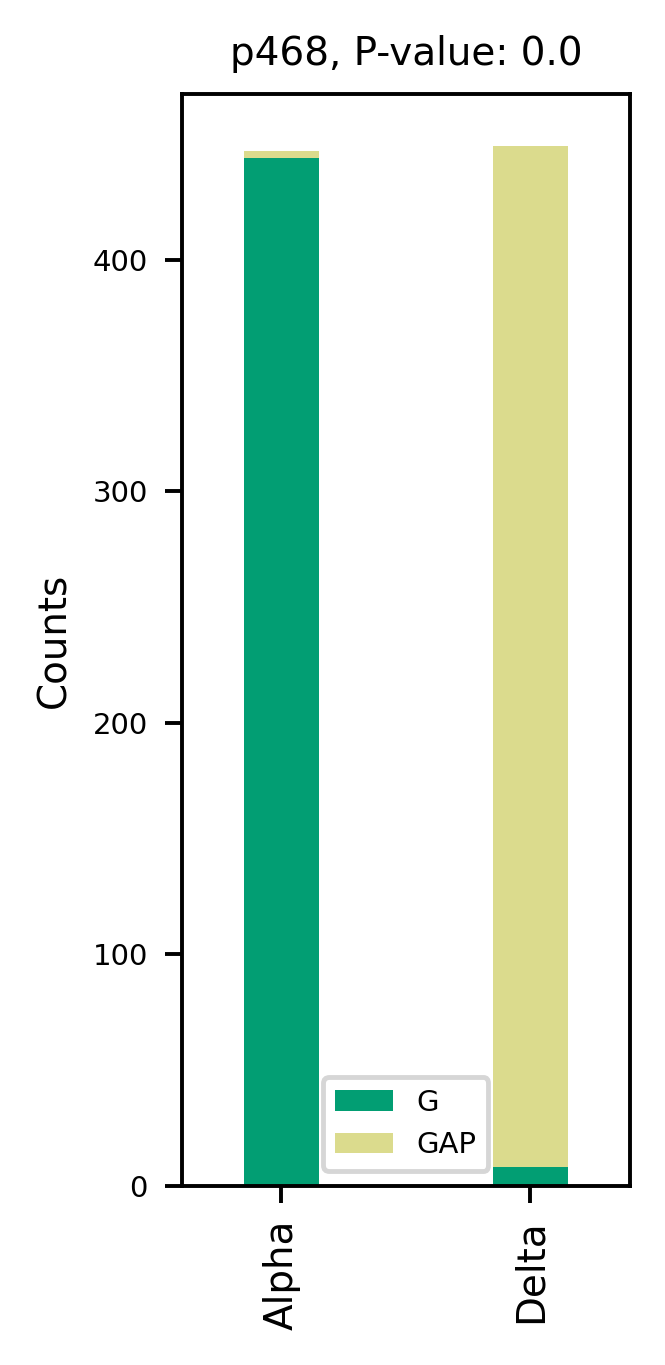

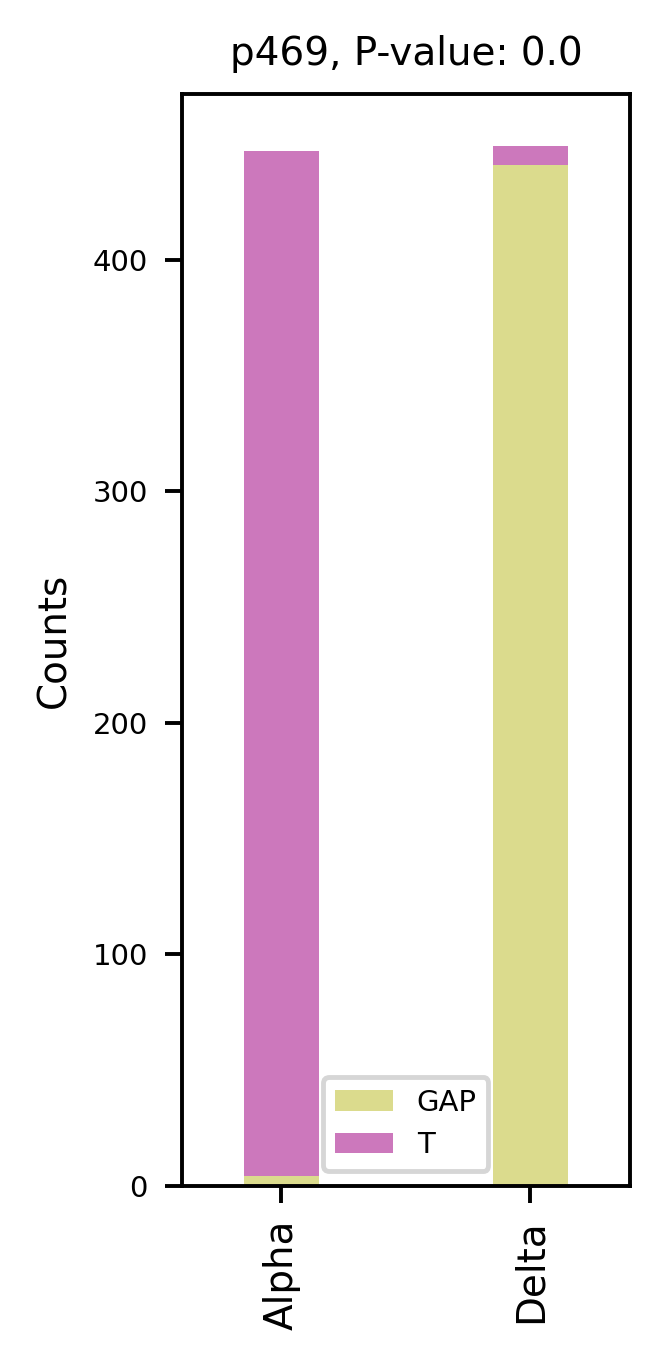

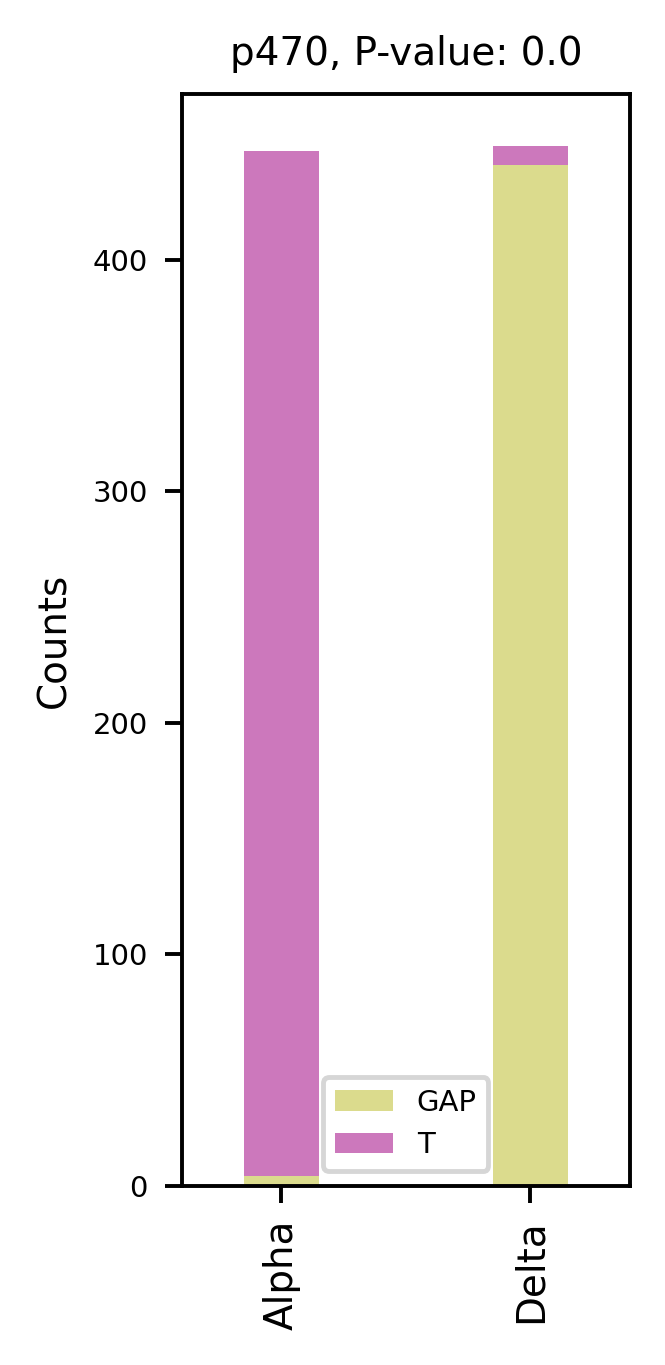

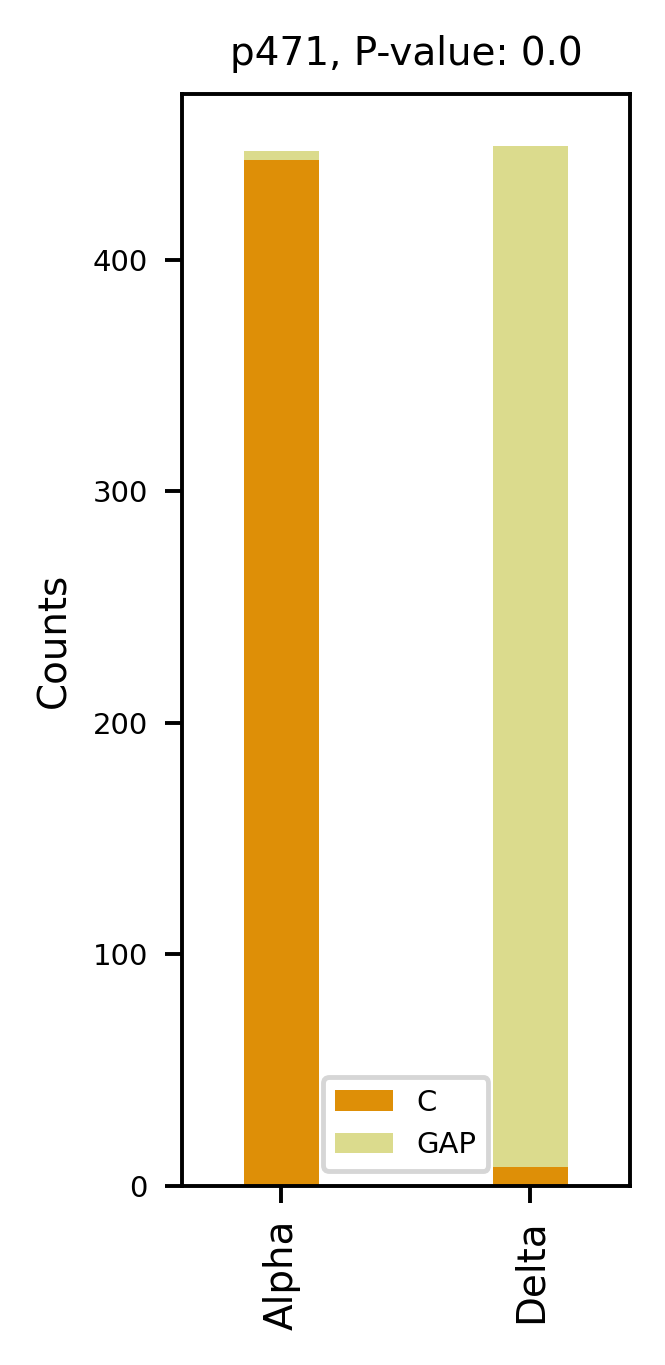

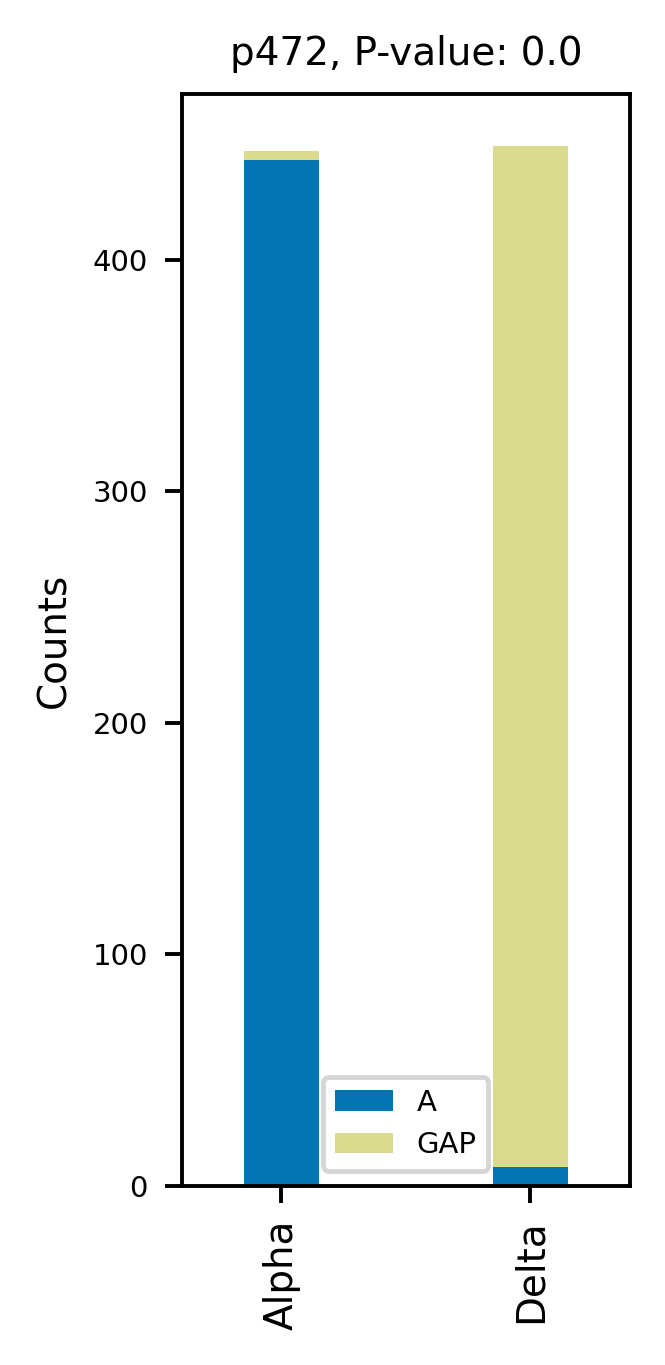

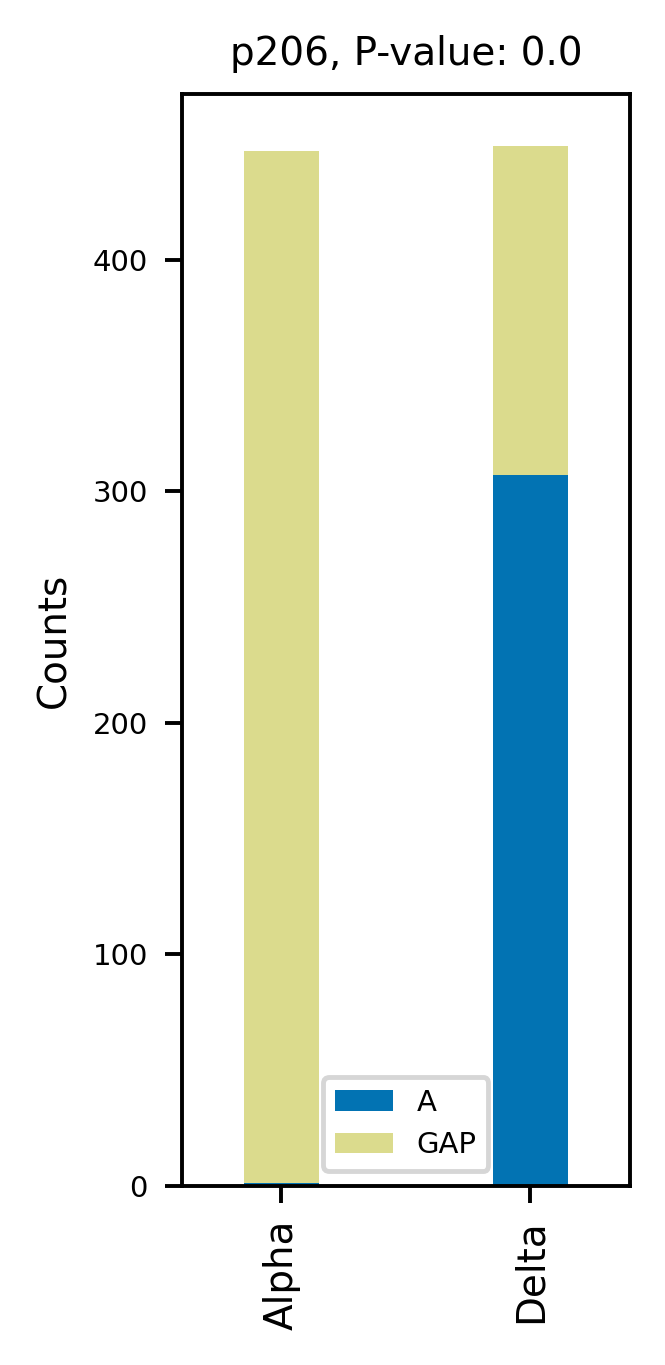

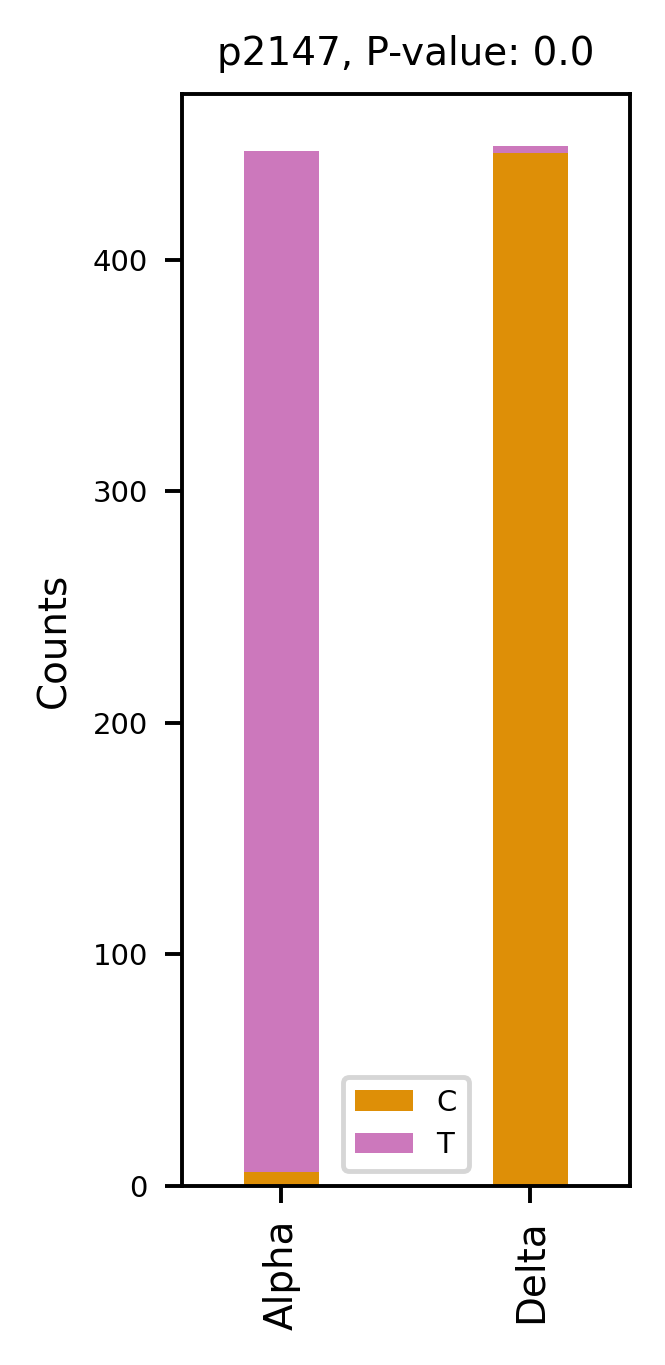

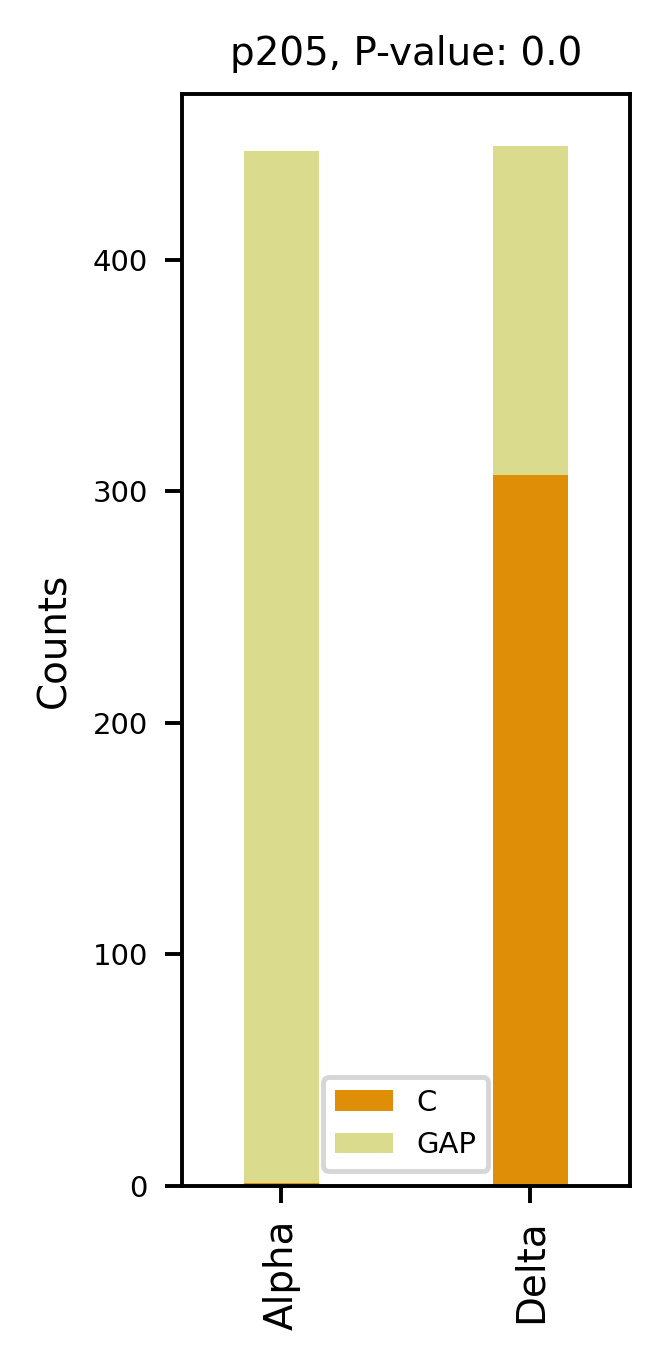

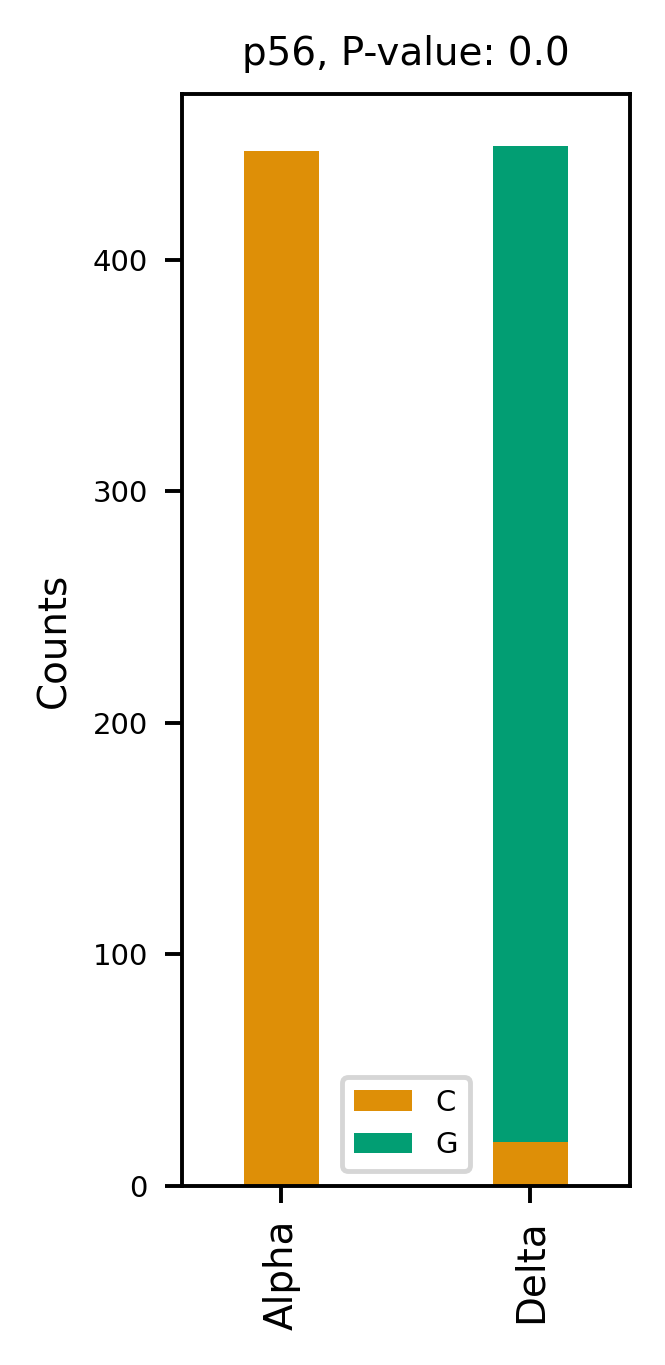

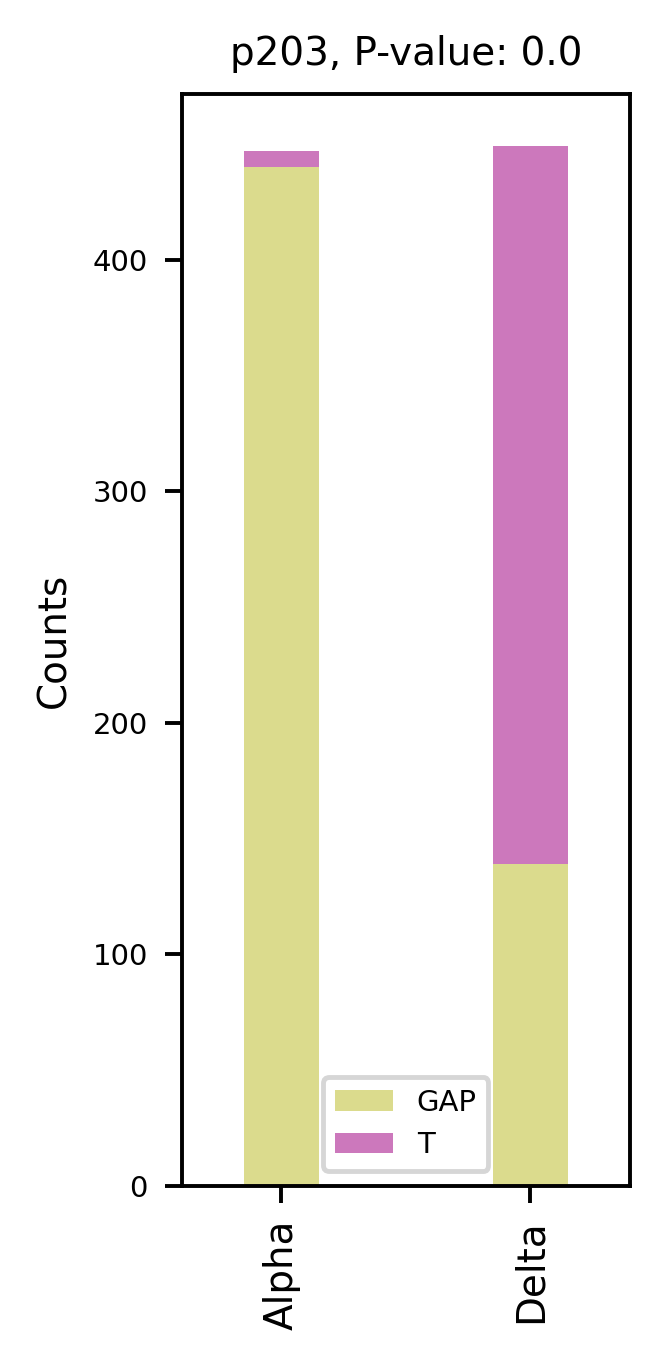

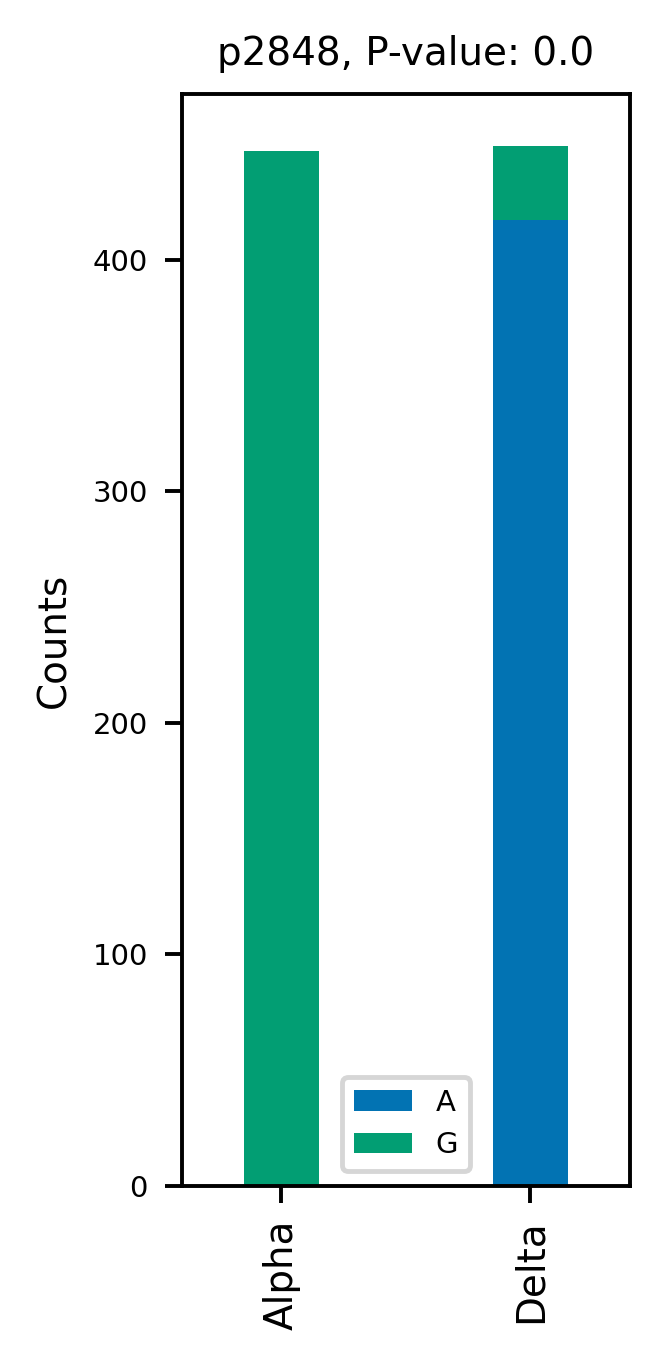

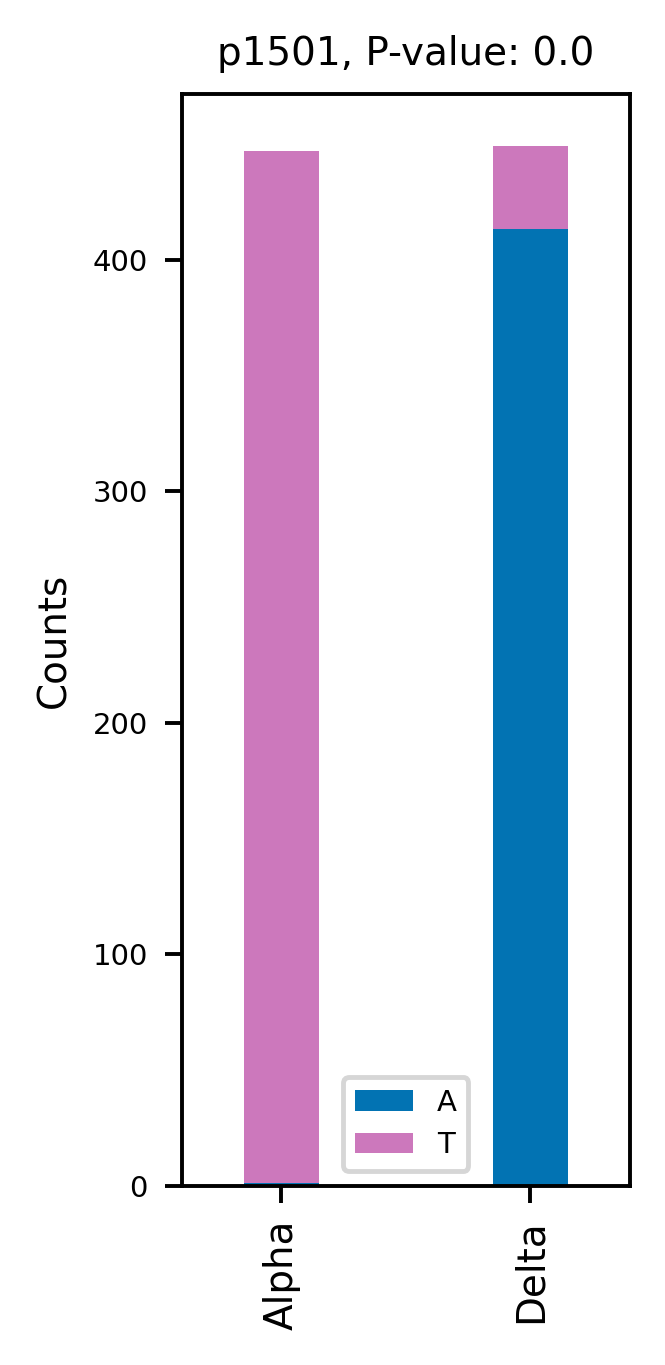

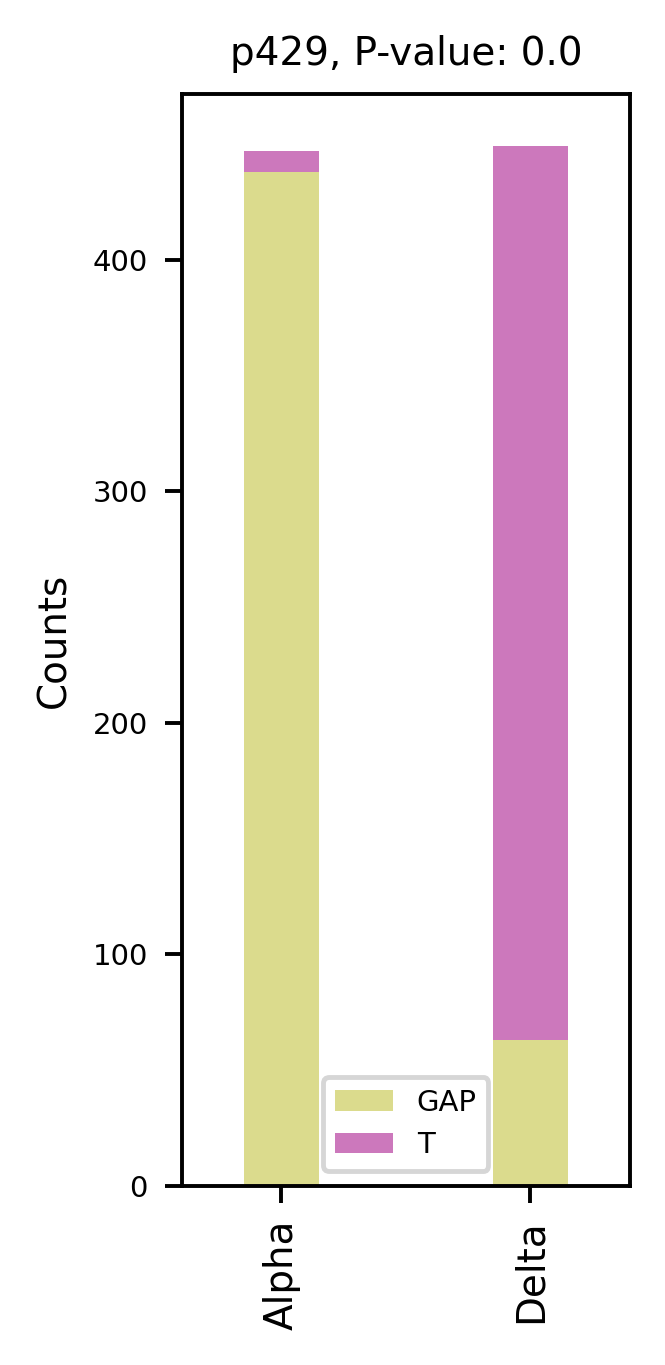

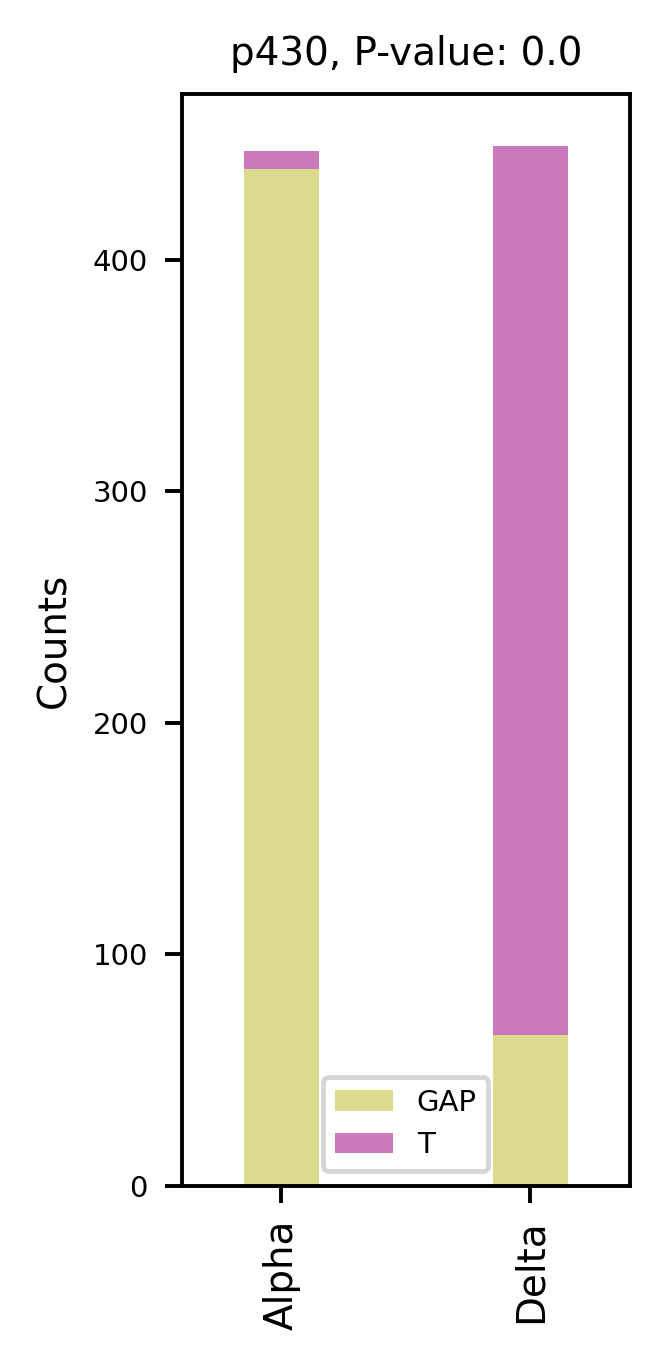

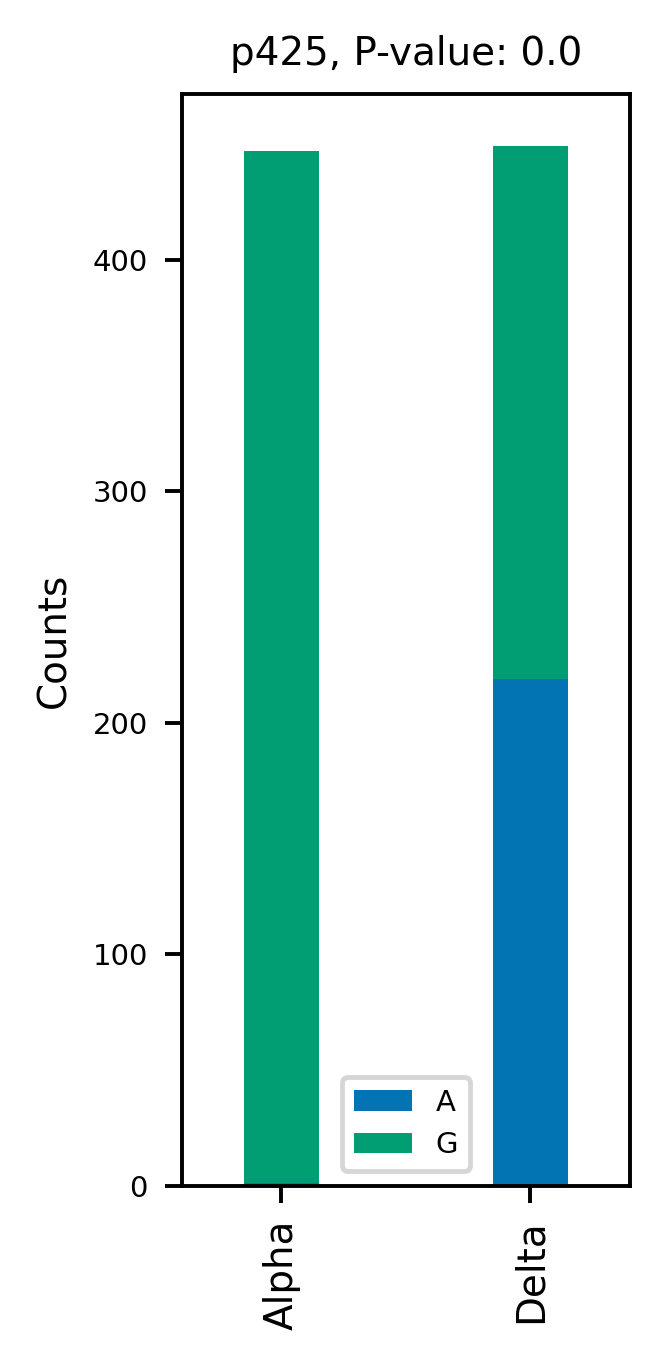

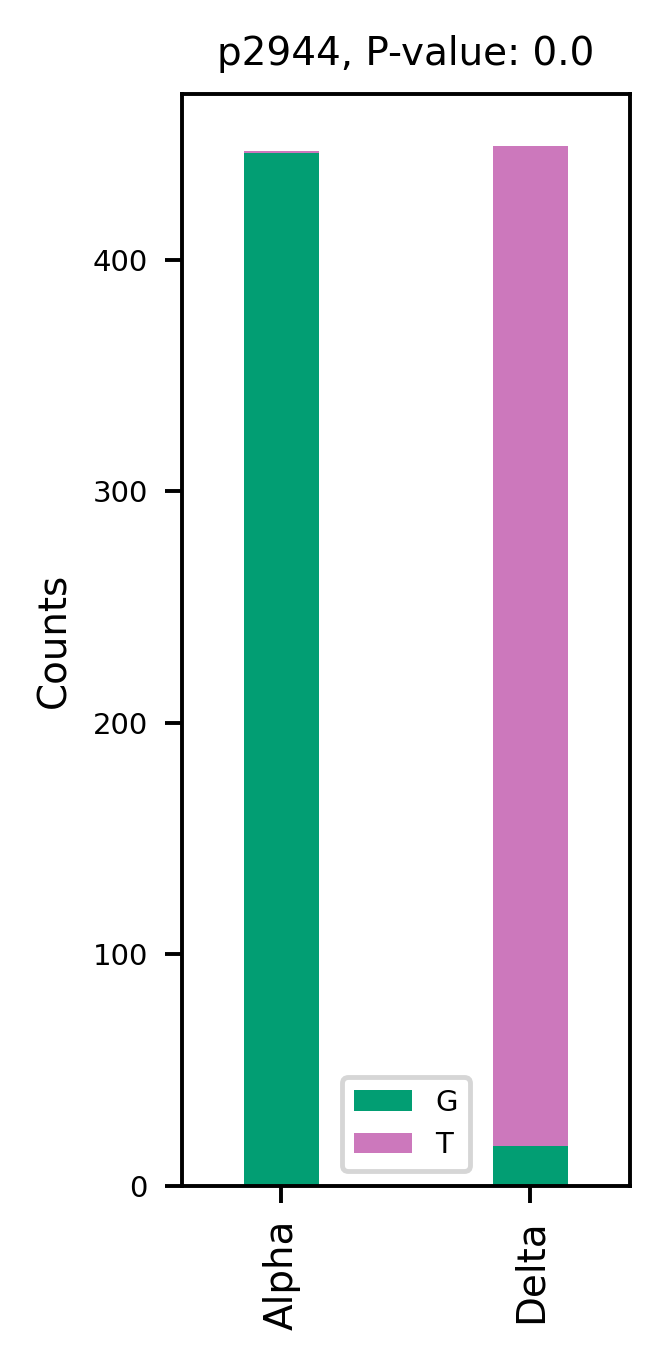

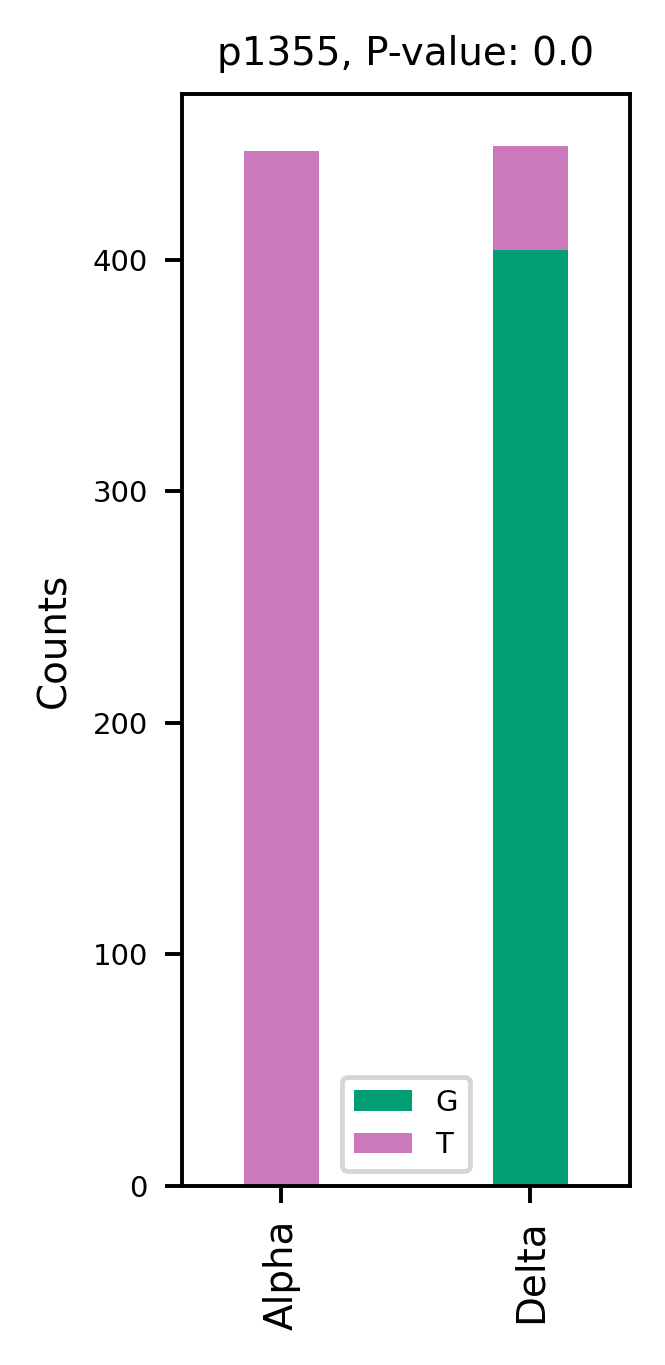

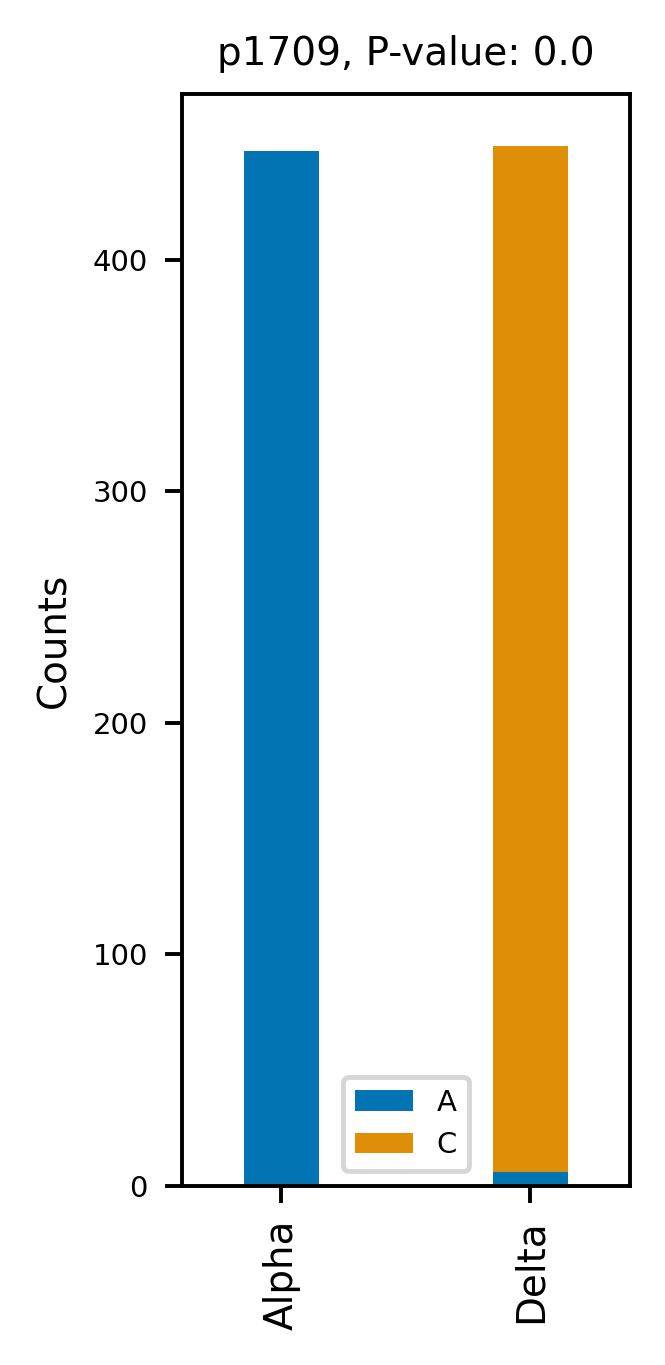

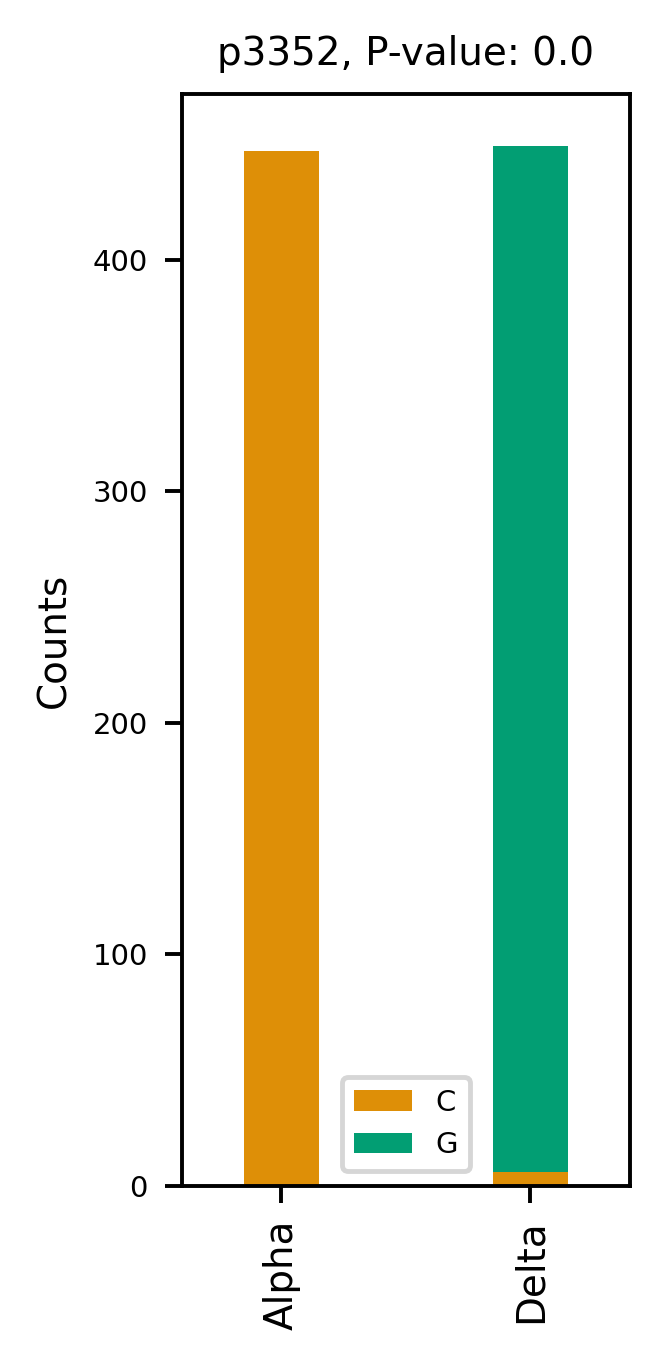

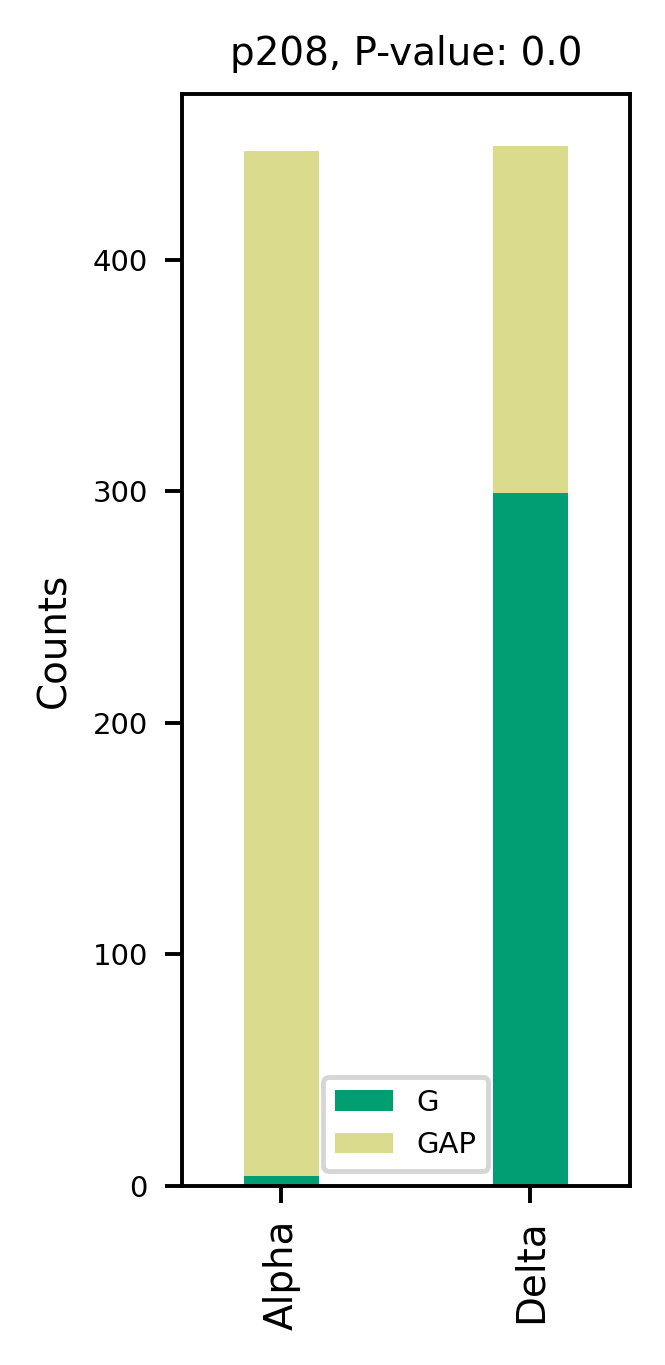

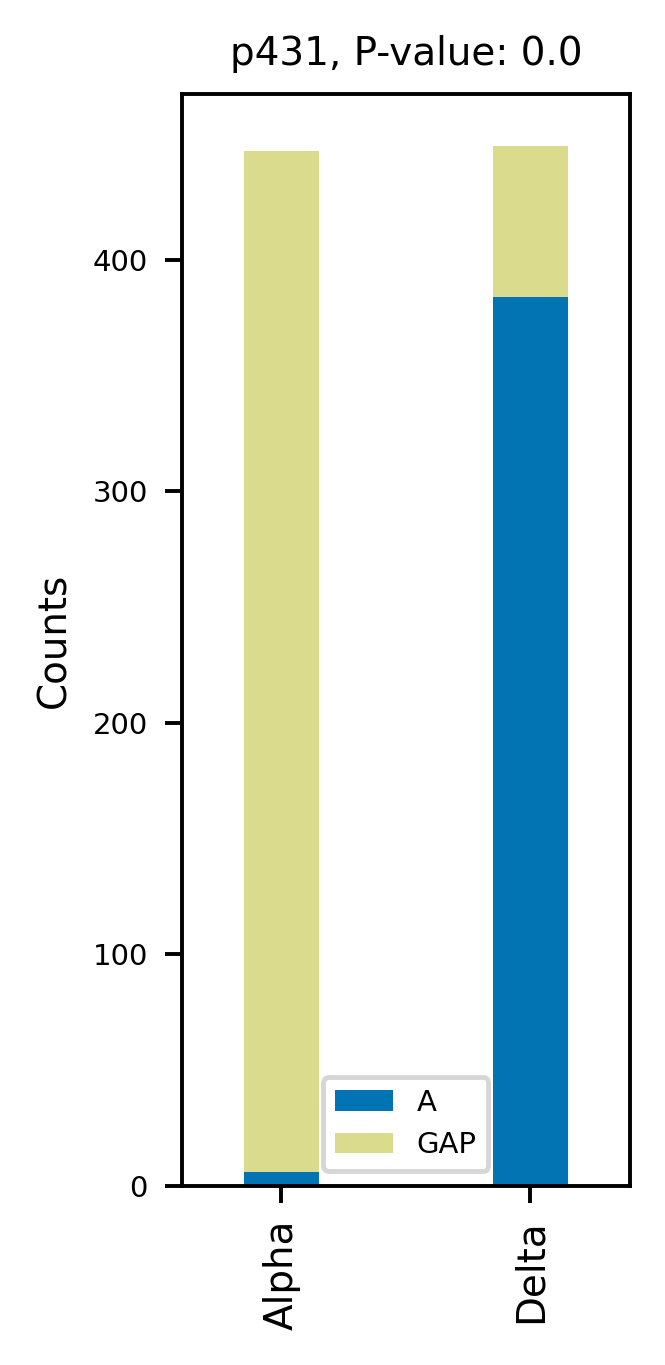

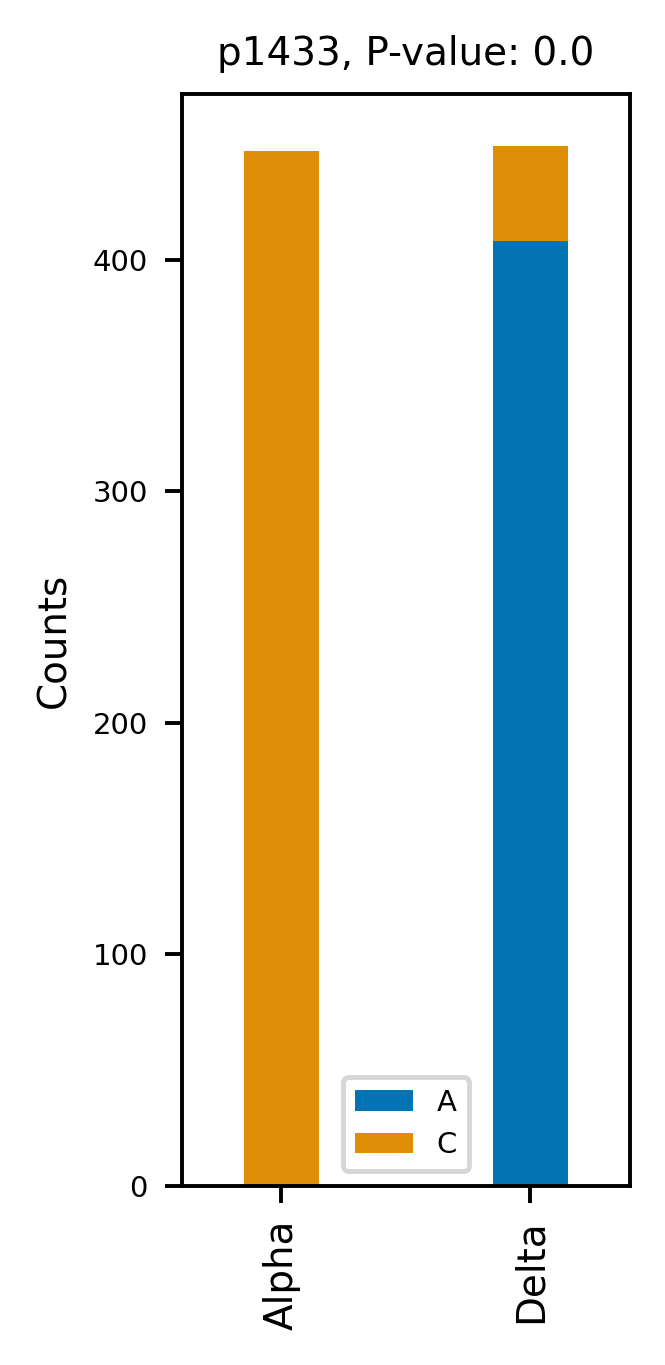

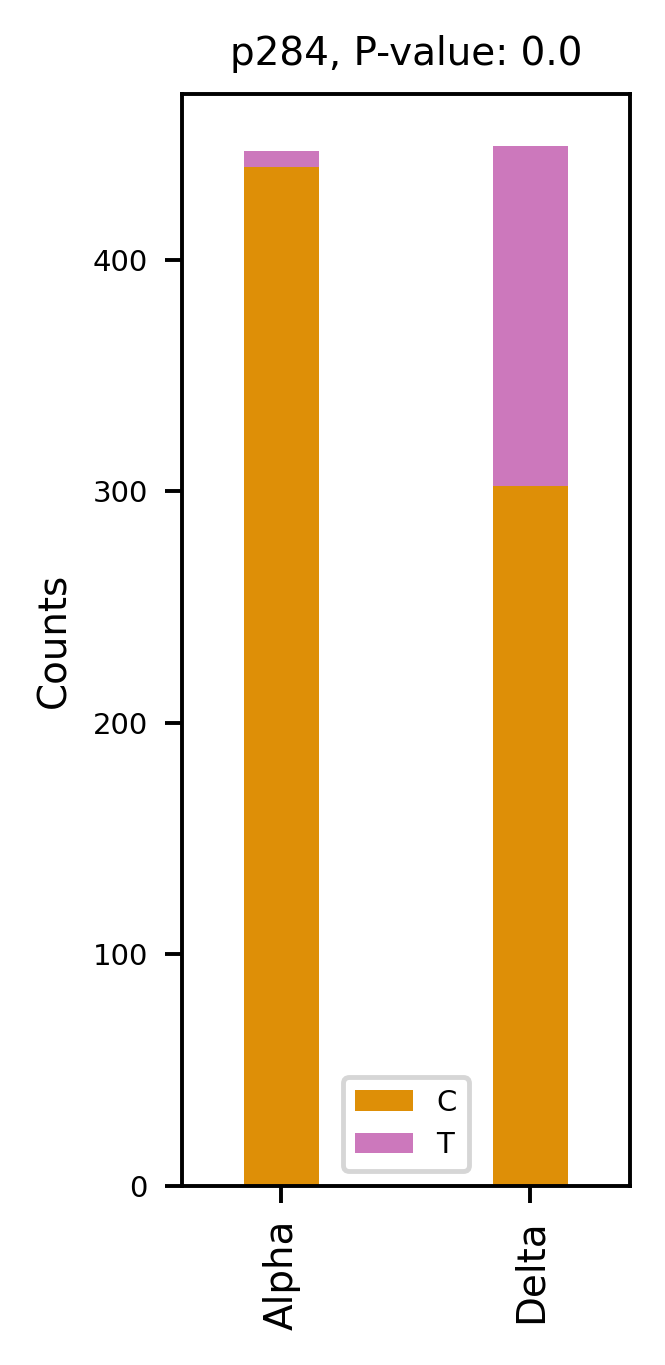

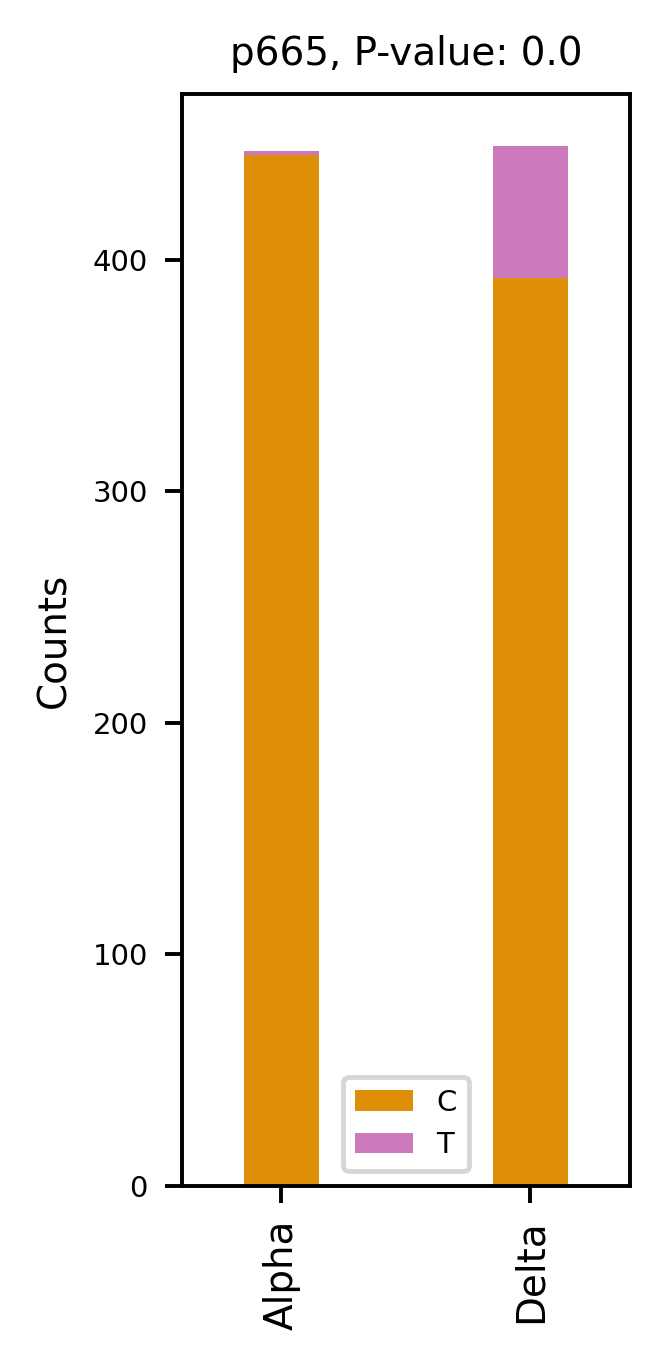

In [50]:
# visualizing top positions  
plots = viz.plot_imp_all(trained_models=trained_models,
                         X_train=df.loc[:, df.columns != mt],
                         y_train=df.loc[:, mt],
                         meta_var=mt,
                         model_type=anaType,
                         report_dir=report_dir,max_plots=100,
                        figsize=(2,4))

In [26]:
import pandas as pd
models = pd.read_csv(report_dir+ '/models_summary.csv', index_col=0)

In [27]:
models

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9745,0.9739,0.9478,1.0,0.9729,0.9489,0.9506,0.337
lr,Logistic Regression,0.9745,0.9739,0.9478,1.0,0.9729,0.9489,0.9506,0.003
xgboost,Extreme Gradient Boosting,0.9745,0.9739,0.9478,1.0,0.9729,0.9489,0.9506,0.016
lightgbm,Light Gradient Boosting Machine,0.9745,0.9739,0.9478,1.0,0.9729,0.9489,0.9506,0.007
rf,Random Forest Classifier,0.9745,0.9739,0.9478,1.0,0.9729,0.9489,0.9506,0.040
gbc,Gradient Boosting Classifier,0.9745,0.9739,0.9478,1.0,0.9729,0.9489,0.9506,0.008
dt,Decision Tree Classifier,0.9745,0.9739,0.9478,1.0,0.9729,0.9489,0.9506,0.002
ada,Ada Boost Classifier,0.9745,0.9739,0.9478,1.0,0.9729,0.9489,0.9506,0.013
ridge,Ridge Classifier,0.9745,0.0000,0.9478,1.0,0.9729,0.9489,0.9506,0.002
svm,SVM - Linear Kernel,0.9745,0.0000,0.9478,1.0,0.9729,0.9489,0.9506,0.003


/Users/mbagh/opt/anaconda3/envs/deepBreaks_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/mbagh/opt/anaconda3/envs/deepBreaks_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/mbagh/opt/anaconda3/envs/deepBreaks_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/mbagh/opt/anaconda3/envs/deepBreaks_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, 